In [1]:
# generate_testing_data_with_sliding_window_best24h.py
"""
Modified version of testing data generation that uses:
1. Sliding window for memory efficiency
2. BEST reverse signal within 24 hours (instead of just next reverse)
"""

import os
import pandas as pd
import numpy as np
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from datetime import datetime

from sliding_window_chan import SlidingWindowChan
from ChanConfig import CChanConfig
from Common.CEnum import KL_TYPE, DATA_SRC, AUTYPE

# Setup recursion limit
sys.setrecursionlimit(30000)

# Configuration
test_ticker = "SPY"
# begin_time = "2022-06-01"
# end_time = "2022-04-01"
begin_time = "2016-01-01"
end_time = "2016-12-31"
lv_list = [KL_TYPE.K_5M]
lv = KL_TYPE.K_5M
data_src = DATA_SRC.CSV
autype = AUTYPE.QFQ

config = CChanConfig({
    "cal_demark": True,
    "cal_kdj": True,
    "cal_dmi": True,
    "cal_rsi": True,
    "cal_rsl": True,
    "cal_demand_index": True,
    "cal_adline": True,
    "cal_bb_vals": True,
    "cal_kc_vals": True,
    "cal_starc_vals": True,
    "bi_strict": True,
    "trigger_step": True,
    "skip_step": 0,
    "divergence_rate": float("inf"),
    "bsp2_follow_1": True,
    "bsp3_follow_1": False,
    "min_zs_cnt": 0,
    "bs1_peak": False,
    "macd_algo": "peak",
    "bs_type": '1,2,3a,1p,2s,3b',
    "print_warning": False,
    "zs_algo": "normal",
})

output_dir = "./output/testing_bs_features"
os.makedirs(output_dir, exist_ok=True)


def collect_all_bsp_during_step_load(chan: SlidingWindowChan, lv: KL_TYPE) -> tuple:
    """
    Uses sliding window's built-in BSP collection.
    """
    print(f"[⏳] STEP 1: Running step load with sliding window...")
    print(f"[🪟] Window size: {chan.max_klines} K-lines")
    
    snapshot_count = 0
    last_print_time = datetime.now()
    final_chan = None
    
    for snapshot_idx, snapshot_chan in enumerate(chan.step_load()):
        snapshot_count = snapshot_idx + 1
        final_chan = snapshot_chan
        
        now = datetime.now()
        if snapshot_idx % 100 == 0 or (now - last_print_time).total_seconds() > 5:
            stats = chan.get_stats()
            print(f"[📈] Snapshot {snapshot_count}: "
                  f"{stats['total_historical_bsp']} BSP collected, "
                  f"window at idx {stats['window_start_idx']}")
            last_print_time = now
    
    all_bsp_data = chan.export_historical_bsp_to_list()
    
    print(f"[✅] Step load complete: {snapshot_count} snapshots processed")
    print(f"[✅] Collected {len(all_bsp_data)} unique BS points (mature + immature)")
    
    stats = chan.get_stats()
    print(f"\n[📊] Sliding Window Stats:")
    print(f"  Window size: {stats['max_klines']} K-lines")
    print(f"  Final window position: idx {stats['window_start_idx']}")
    if 'current_window_size' in stats:
        print(f"  Current K-lines in window: {stats['current_window_size']}")
    
    return all_bsp_data, final_chan


def calculate_profit_targets_best_within_24h(
    bs_points_with_features: list, 
    time_window_bars: int = 120
) -> dict:
    """
    Calculate profit targets using the BEST reverse signal within a time window.
    
    For BUY signals: Find SELL signal with HIGHEST price within window (max profit)
    For SELL signals: Find BUY signal with LOWEST price within window (max profit)
    
    Args:
        bs_points_with_features: List of BS points with features
        time_window_bars: Number of bars to look ahead (default 288 = 24h of 5-min data)
    
    Returns:
        Dictionary mapping klu_idx to profit target info
    """
    print(f"[🎯] STEP 2: Calculating profit targets using BEST within {time_window_bars} bars (~24h)...")
    
    # Sort by klu_idx to ensure temporal order
    bs_points_with_features.sort(key=lambda x: x['klu_idx'])
    
    profit_targets = {}
    
    for i, data in enumerate(bs_points_with_features):
        current_direction = data['is_buy']
        entry_price = data['klu_close']
        entry_idx = data['klu_idx']
        
        # Initialize
        profit_targets[entry_idx] = {
            'profit_target_pct': None,
            'profit_target_distance': None,
            'has_profit_target': 0,
            'exit_type': None,
            'exit_klu_idx': None,
            'exit_price': None,
        }
        
        # Define the search window (24 hours worth of bars)
        window_end_idx = entry_idx + time_window_bars
        
        # Find ALL reverse signals within the window
        candidates_in_window = []
        fallback_next_reverse = None
        
        for j in range(i + 1, len(bs_points_with_features)):
            future_data = bs_points_with_features[j]
            future_idx = future_data['klu_idx']
            
            # Check if opposite direction
            if future_data['is_buy'] != current_direction:
                # Track first reverse signal as fallback
                if fallback_next_reverse is None:
                    fallback_next_reverse = future_data
                
                # Add to candidates if within window
                if future_idx <= window_end_idx:
                    candidates_in_window.append(future_data)
        
        # Select the BEST candidate within window
        best_exit = None
        
        if candidates_in_window:
            if current_direction:  # BUY signal
                # Find SELL with HIGHEST price (maximum profit for buy)
                best_exit = max(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
            else:  # SELL signal
                # Find BUY with LOWEST price (maximum profit for sell)
                best_exit = min(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
        elif fallback_next_reverse:
            # No reverse signal in 24h window, use next reverse as fallback
            best_exit = fallback_next_reverse
            exit_type = 'fallback_next'
        
        if best_exit is None:
            continue
        
        # Calculate profit percentage
        exit_price = best_exit['klu_close']
        
        if current_direction:  # BUY -> exit at SELL
            profit_pct = (exit_price - entry_price) / entry_price * 100
        else:  # SELL -> exit at BUY
            profit_pct = (entry_price - exit_price) / entry_price * 100
        
        # Store results
        profit_targets[entry_idx] = {
            'profit_target_pct': profit_pct,
            'profit_target_distance': best_exit['klu_idx'] - entry_idx,
            'has_profit_target': 1,
            'exit_type': exit_type,
            'exit_klu_idx': best_exit['klu_idx'],
            'exit_price': exit_price,
        }
    
    # Summary statistics
    valid_targets = [v for v in profit_targets.values() if v['has_profit_target'] == 1]
    
    if valid_targets:
        profits = [v['profit_target_pct'] for v in valid_targets]
        distances = [v['profit_target_distance'] for v in valid_targets]
        exit_types = [v['exit_type'] for v in valid_targets]
        
        best_24h_count = sum(1 for et in exit_types if et == 'best_24h')
        fallback_count = sum(1 for et in exit_types if et == 'fallback_next')
        
        print(f"[📊] Profit Target Summary (BEST within 24h):")
        print(f"  Total BS points: {len(bs_points_with_features)}")
        print(f"  Points with targets: {len(valid_targets)} ({len(valid_targets)/len(bs_points_with_features)*100:.1f}%)")
        print(f"  Exit types:")
        print(f"    - Best within 24h: {best_24h_count} ({best_24h_count/len(valid_targets)*100:.1f}%)")
        print(f"    - Fallback (next reverse): {fallback_count} ({fallback_count/len(valid_targets)*100:.1f}%)")
        print(f"  Average profit: {np.mean(profits):.2f}%")
        print(f"  Median profit: {np.median(profits):.2f}%")
        print(f"  Best profit: {max(profits):.2f}%")
        print(f"  Worst result: {min(profits):.2f}%")
        print(f"  Average distance: {np.mean(distances):.1f} bars")
        print(f"  Profitable trades: {sum(1 for p in profits if p > 0)}/{len(profits)} ({sum(1 for p in profits if p > 0)/len(profits)*100:.1f}%)")
    
    return profit_targets


def prepare_ml_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare dataset for ML"""
    if df.empty:
        return df
    
    print("[🔧] Preparing final ML dataset...")
    
    categorical_cols = ['direction', 'timestamp']
    binary_cols = [col for col in df.columns if col.endswith(('_signal', '_oversold', '_overbought', '_positive', '_up', '_trend_up'))]
    binary_cols.extend(['is_buy', 'is_bullish_candle', 'has_profit_target'])
    
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in categorical_cols and col not in binary_cols]
    
    if numeric_cols:
        numeric_imputer = SimpleImputer(strategy='mean')
        df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
    
    if binary_cols:
        existing_binary_cols = [col for col in binary_cols if col in df.columns]
        if existing_binary_cols:
            binary_imputer = SimpleImputer(strategy='most_frequent')
            df[existing_binary_cols] = binary_imputer.fit_transform(df[existing_binary_cols])
    
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna('unknown')
    
    for col in ['direction']:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    
    df = df.replace([np.inf, -np.inf], np.nan)
    numeric_cols_final = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols_final] = df[numeric_cols_final].fillna(0)
    
    print(f"[✅] Dataset prepared with {len(df)} samples and {len(df.columns)} features")
    return df


def analyze_testing_dataset(df: pd.DataFrame):
    """Analyze testing dataset"""
    print(f"\n[📊] Testing Dataset Analysis:")
    print(f"  Total BS points: {len(df)}")
    print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    
    print(f"\n  Signal Distribution:")
    for direction in ['buy', 'sell']:
        count = (df['direction'] == direction).sum()
        print(f"    {direction.capitalize()}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'bsp_type' in df.columns:
        print(f"\n  BSP Type Distribution:")
        for bsp_type in sorted(df['bsp_type'].unique()):
            count = (df['bsp_type'] == bsp_type).sum()
            print(f"    {bsp_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'exit_type' in df.columns:
        print(f"\n  Exit Type Distribution:")
        exit_counts = df['exit_type'].value_counts()
        for exit_type, count in exit_counts.items():
            if exit_type:
                print(f"    {exit_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'profit_target_pct' in df.columns:
        profit_data = df['profit_target_pct'].dropna()
        if len(profit_data) > 0:
            profitable = (profit_data > 0).sum()
            print(f"\n  Profit Target Performance:")
            print(f"    Points with targets: {len(profit_data)} ({len(profit_data)/len(df)*100:.1f}%)")
            print(f"    Profitable trades: {profitable} ({profitable/len(profit_data)*100:.1f}%)")
            print(f"    Average profit: {profit_data.mean():.2f}%")
            print(f"    Median profit: {profit_data.median():.2f}%")
            print(f"    Min/Max: {profit_data.min():.2f}% / {profit_data.max():.2f}%")


def export_testing_dataset(
    chan: SlidingWindowChan,
    lv: KL_TYPE,
    output_path: str,
    time_window_bars: int = 288,
) -> pd.DataFrame:
    """
    Export testing dataset with BEST within 24h profit logic.
    """
    print(f"[📊] Generating testing dataset with sliding window...")
    print(f"[🔄] Process:")
    print("  STEP 1: Sliding window auto-captures ALL BS points")
    print(f"  STEP 2: Calculate profit targets (BEST within {time_window_bars} bars)")
    
    # STEP 1: Collect all BS points
    all_bsp_data, final_chan = collect_all_bsp_during_step_load(chan, lv)
    
    if not all_bsp_data:
        print("[⚠️] No BS points collected during step load")
        return pd.DataFrame()
    
    # STEP 2: Calculate profit targets using BEST within 24h
    profit_targets = calculate_profit_targets_best_within_24h(
        all_bsp_data, 
        time_window_bars=time_window_bars
    )
    
    # Add profit targets to each row
    for row in all_bsp_data:
        klu_idx = row['klu_idx']
        if klu_idx in profit_targets:
            row.update(profit_targets[klu_idx])
        else:
            row['profit_target_pct'] = None
            row['profit_target_distance'] = None
            row['has_profit_target'] = 0
            row['exit_type'] = None
            row['exit_klu_idx'] = None
            row['exit_price'] = None
    
    # Convert to DataFrame
    df = pd.DataFrame(all_bsp_data)
    
    # Sort by klu_idx
    df = df.sort_values('klu_idx').reset_index(drop=True)
    
    # Prepare final dataset
    df = prepare_ml_dataset(df)
    
    # Analyze dataset
    analyze_testing_dataset(df)
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    print(f"[💾] Saved testing dataset to: {output_path}")
    
    return df


def main():
    try:
        print(f"[🧪] Generating TESTING dataset with SLIDING WINDOW")
        print(f"[📊] Ticker: {test_ticker}")
        print(f"[📅] Period: {begin_time} to {end_time}")
        print(f"[🪟] Window: 1000 K-lines (configurable)")
        print(f"[🎯] Profit Logic: BEST reverse signal within 24 hours")
        
        # Calculate appropriate time window based on K-line type
        time_windows = {
            KL_TYPE.K_5M: 288,   # 24 hours = 288 5-min bars
            KL_TYPE.K_15M: 96,   # 24 hours = 96 15-min bars
            KL_TYPE.K_30M: 48,   # 24 hours = 48 30-min bars
            KL_TYPE.K_60M: 24,   # 24 hours = 24 1-hour bars
            KL_TYPE.K_DAY: 1,    # 24 hours = 1 day bar
        }
        
        time_window = time_windows.get(lv, 288)
        print(f"[⏰] Time window: {time_window} bars (~24 hours for {lv.name})")
        
        # Create sliding window Chan
        chan = SlidingWindowChan(
            code=test_ticker,
            begin_time=begin_time,
            end_time=end_time,
            data_src=data_src,
            lv_list=lv_list,
            config=config,
            autype=autype,
            max_klines=1000
        )
        
        # Export testing dataset
        output_file = os.path.join(output_dir, f"{test_ticker}_testing_dataset_16.1.1-12.31.csv")
        df = export_testing_dataset(
            chan=chan,
            lv=lv,
            output_path=output_file,
            time_window_bars=time_window,
        )
        
        if df is not None and not df.empty:
            # Display sample data
            print("\n[📋] Sample of testing data:")
            sample_cols = ['klu_idx', 'bsp_type', 'direction', 'snapshot_first_seen',
                          'profit_target_pct', 'profit_target_distance', 'exit_type', 
                          'has_profit_target']
            available_sample_cols = [col for col in sample_cols if col in df.columns]
            print(df[available_sample_cols].head(20))
            
            # Sliding window benefits
            stats = chan.get_stats()
            print(f"\n[🪟] Sliding Window Benefits:")
            print(f"  ✅ Memory efficient: Only {stats['max_klines']} K-lines in RAM")
            print(f"  ✅ Faster processing: Smaller Chan system to recalculate")
            print(f"  ✅ Complete data: All {stats['total_historical_bsp']} BSP preserved")
            print(f"  ✅ Scalable: Can process unlimited historical data")
            print(f"  ✅ Better targets: Uses BEST exit within 24h (not just next)")
            
            # Save metadata
            metadata_path = os.path.join(output_dir, f"{test_ticker}_best24h_metadata.txt")
            with open(metadata_path, 'w') as f:
                f.write("Testing Dataset with BEST within 24h Logic\n")
                f.write("=" * 50 + "\n\n")
                
                f.write("PROFIT TARGET CALCULATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Method: BEST reverse signal within {time_window} bars (~24 hours)\n")
                f.write("Logic:\n")
                f.write("  - BUY signals: Find SELL with HIGHEST price in window\n")
                f.write("  - SELL signals: Find BUY with LOWEST price in window\n")
                f.write("  - Fallback: Uses next reverse if no signal in window\n\n")
                
                f.write("ADVANTAGES over 'Next Reverse' method:\n")
                f.write("-" * 30 + "\n")
                f.write("1. Captures MAXIMUM profit potential within timeframe\n")
                f.write("2. More realistic (traders wait for best exit, not just first)\n")
                f.write("3. Aligned with actual trading behavior\n")
                f.write("4. Still time-constrained (24h) to avoid overfitting\n\n")
                
                f.write("SLIDING WINDOW CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Window Size: {stats['max_klines']} K-lines\n")
                f.write(f"Final Window Position: idx {stats['window_start_idx']}\n")
                f.write(f"Total BSP Collected: {stats['total_historical_bsp']}\n\n")
                
                f.write("CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Ticker: {test_ticker}\n")
                f.write(f"Period: {begin_time} to {end_time}\n")
                f.write(f"Level: {lv.name}\n")
                f.write(f"Time Window: {time_window} bars (~24 hours)\n")
                f.write(f"Total Samples: {len(df)}\n")
                f.write(f"Samples with Targets: {df['has_profit_target'].sum()}\n")
                
                if 'exit_type' in df.columns:
                    f.write(f"\nExit Type Distribution:\n")
                    exit_counts = df['exit_type'].value_counts()
                    for exit_type, count in exit_counts.items():
                        if exit_type:
                            f.write(f"  {exit_type}: {count} ({count/len(df)*100:.1f}%)\n")
            
            print(f"[📝] Metadata saved to: {metadata_path}")
            
            print("\n[✅] Testing dataset generation complete!")
            print(f"\n[🎯] Key Features:")
            print(f"  ✅ Uses BEST exit within 24h (max profit potential)")
            print(f"  ✅ More realistic than 'next reverse' logic")
            print(f"  ✅ Captures ALL BS points during step load")
            print(f"  ✅ No future data in features")
            print(f"  ✅ Memory efficient with sliding window")
            print(f"  ✅ Ready for model testing")
        
        return df
        
    except Exception as e:
        print(f"[❌] Error: {e}")
        import traceback
        traceback.print_exc()
        return None


if __name__ == "__main__":
    import time
    
    start_time = time.time()
    
    # Run the testing dataset generation
    testing_data = main()
    
    end_time = time.time()
    print(f"\n⏱️ Total processing time: {end_time - start_time:.2f} seconds")
    
    if testing_data is not None and not testing_data.empty:
        print("\n[🧪] Testing Dataset Ready!")
        print(f"Dataset shape: {testing_data.shape}")
        
        print(f"\n[📊] This dataset uses:")
        print(f"  ✅ BEST reverse signal within 24h (max profit)")
        print(f"  ✅ More realistic exit logic")
        print(f"  ✅ Features without future data leak")
        print(f"  ✅ Generated efficiently with sliding window")
    else:
        print("[❌] No testing data was generated.")

[🧪] Generating TESTING dataset with SLIDING WINDOW
[📊] Ticker: SPY
[📅] Period: 2016-01-01 to 2016-12-31
[🪟] Window: 1000 K-lines (configurable)
[🎯] Profit Logic: BEST reverse signal within 24 hours
[⏰] Time window: 288 bars (~24 hours for K_5M)
[📊] Generating testing dataset with sliding window...
[🔄] Process:
  STEP 1: Sliding window auto-captures ALL BS points
  STEP 2: Calculate profit targets (BEST within 288 bars)
[⏳] STEP 1: Running step load with sliding window...
[🪟] Window size: 1000 K-lines
[📥] Loading K-lines from data source...
CSV_API: Processed 1044283 lines, filtered to 46272 lines
[✅] Loaded 46272 K-lines from source
[🪟] Starting sliding window processing (window size: 1000)
[📊] Total K-lines to process: 46272
[📈] Snapshot 1: 0 BSP collected, window at idx 0
[📈] Snapshot 101: 14 BSP collected, window at idx 0
[📈] Snapshot 201: 36 BSP collected, window at idx 0
[📈] Snapshot 301: 49 BSP collected, window at idx 0
[📈] Snapshot 401: 71 BSP collected, window at idx 0
[📈] Sna

In [ ]:
from normalized_sliding_window_chan import NormalizedSlidingWindowChan

from ChanConfig import CChanConfig
from Common.CEnum import KL_TYPE, DATA_SRC, AUTYPE
import os
import pandas as pd
import numpy as np
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from datetime import datetime
sys.setrecursionlimit(30000)

# Configuration
test_ticker = "SPY"
# begin_time = "2022-06-01"
# end_time = "2022-04-01"
begin_time = "2018-01-01"
end_time = "2018-12-31"
lv_list = [KL_TYPE.K_5M]
lv = KL_TYPE.K_5M
data_src = DATA_SRC.CSV
autype = AUTYPE.QFQ

config = CChanConfig({
    "cal_demark": True,
    "cal_kdj": True,
    "cal_dmi": True,
    "cal_rsi": True,
    "cal_rsl": True,
    "cal_demand_index": True,
    "cal_adline": True,
    "cal_bb_vals": True,
    "cal_kc_vals": True,
    "cal_starc_vals": True,
    "bi_strict": True,
    "trigger_step": True,
    "skip_step": 0,
    "divergence_rate": float("inf"),
    "bsp2_follow_1": True,
    "bsp3_follow_1": False,
    "min_zs_cnt": 0,
    "bs1_peak": False,
    "macd_algo": "peak",
    "bs_type": '1,2,3a,1p,2s,3b',
    "print_warning": False,
    "zs_algo": "normal",
})

output_dir = "./output/testing_bs_features"
os.makedirs(output_dir, exist_ok=True)


def collect_all_bsp_during_step_load(chan: NormalizedSlidingWindowChan, lv: KL_TYPE) -> tuple:
    """
    Uses sliding window's built-in BSP collection with normalization.
    """
    print(f"[⏳] STEP 1: Running step load with normalized sliding window...")
    print(f"[🪟] Window size: {chan.max_klines} K-lines")
    print(f"[🧮] Normalization: {chan.normalization_type} ({'window' if chan.window_normalization else 'global'})")
    
    snapshot_count = 0
    last_print_time = datetime.now()
    final_chan = None
    
    for snapshot_idx, snapshot_chan in enumerate(chan.step_load()):
        snapshot_count = snapshot_idx + 1
        final_chan = snapshot_chan
        
        now = datetime.now()
        if snapshot_idx % 100 == 0 or (now - last_print_time).total_seconds() > 5:
            stats = chan.get_stats()
            print(f"[📈] Snapshot {snapshot_count}: "
                  f"{stats['total_historical_bsp']} BSP collected, "
                  f"window at idx {stats['window_start_idx']}")
            last_print_time = now
    
    all_bsp_data = chan.export_historical_bsp_to_list()
    
    print(f"[✅] Step load complete: {snapshot_count} snapshots processed")
    print(f"[✅] Collected {len(all_bsp_data)} unique BS points (mature + immature)")
    
    stats = chan.get_stats()
    print(f"\n[📊] Normalized Sliding Window Stats:")
    print(f"  Window size: {stats['max_klines']} K-lines")
    print(f"  Final window position: idx {stats['window_start_idx']}")
    if 'current_window_size' in stats:
        print(f"  Current K-lines in window: {stats['current_window_size']}")
    print(f"  Normalization type: {stats['normalization_type']}")
    print(f"  Window normalization: {stats['window_normalization']}")
    
    return all_bsp_data, final_chan


def calculate_profit_targets_best_within_24h(
    bs_points_with_features: list, 
    time_window_bars: int = 120
) -> dict:
    """
    Calculate profit targets using the BEST reverse signal within a time window.
    
    For BUY signals: Find SELL signal with HIGHEST price within window (max profit)
    For SELL signals: Find BUY signal with LOWEST price within window (max profit)
    
    Args:
        bs_points_with_features: List of BS points with features
        time_window_bars: Number of bars to look ahead (default 288 = 24h of 5-min data)
    
    Returns:
        Dictionary mapping klu_idx to profit target info
    """
    print(f"[🎯] STEP 2: Calculating profit targets using BEST within {time_window_bars} bars (~24h)...")
    
    # Sort by klu_idx to ensure temporal order
    bs_points_with_features.sort(key=lambda x: x['klu_idx'])
    
    profit_targets = {}
    
    for i, data in enumerate(bs_points_with_features):
        current_direction = data['is_buy']
        entry_price = data['klu_close']
        entry_idx = data['klu_idx']
        
        # Initialize
        profit_targets[entry_idx] = {
            'profit_target_pct': None,
            'profit_target_distance': None,
            'has_profit_target': 0,
            'exit_type': None,
            'exit_klu_idx': None,
            'exit_price': None,
        }
        
        # Define the search window (24 hours worth of bars)
        window_end_idx = entry_idx + time_window_bars
        
        # Find ALL reverse signals within the window
        candidates_in_window = []
        fallback_next_reverse = None
        
        for j in range(i + 1, len(bs_points_with_features)):
            future_data = bs_points_with_features[j]
            future_idx = future_data['klu_idx']
            
            # Check if opposite direction
            if future_data['is_buy'] != current_direction:
                # Track first reverse signal as fallback
                if fallback_next_reverse is None:
                    fallback_next_reverse = future_data
                
                # Add to candidates if within window
                if future_idx <= window_end_idx:
                    candidates_in_window.append(future_data)
        
        # Select the BEST candidate within window
        best_exit = None
        
        if candidates_in_window:
            if current_direction:  # BUY signal
                # Find SELL with HIGHEST price (maximum profit for buy)
                best_exit = max(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
            else:  # SELL signal
                # Find BUY with LOWEST price (maximum profit for sell)
                best_exit = min(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
        elif fallback_next_reverse:
            # No reverse signal in 24h window, use next reverse as fallback
            best_exit = fallback_next_reverse
            exit_type = 'fallback_next'
        
        if best_exit is None:
            continue
        
        # Calculate profit percentage
        exit_price = best_exit['klu_close']
        
        if current_direction:  # BUY -> exit at SELL
            profit_pct = (exit_price - entry_price) / entry_price * 100
        else:  # SELL -> exit at BUY
            profit_pct = (entry_price - exit_price) / entry_price * 100
        
        # Store results
        profit_targets[entry_idx] = {
            'profit_target_pct': profit_pct,
            'profit_target_distance': best_exit['klu_idx'] - entry_idx,
            'has_profit_target': 1,
            'exit_type': exit_type,
            'exit_klu_idx': best_exit['klu_idx'],
            'exit_price': exit_price,
        }
    
    # Summary statistics
    valid_targets = [v for v in profit_targets.values() if v['has_profit_target'] == 1]
    
    if valid_targets:
        profits = [v['profit_target_pct'] for v in valid_targets]
        distances = [v['profit_target_distance'] for v in valid_targets]
        exit_types = [v['exit_type'] for v in valid_targets]
        
        best_24h_count = sum(1 for et in exit_types if et == 'best_24h')
        fallback_count = sum(1 for et in exit_types if et == 'fallback_next')
        
        print(f"[📊] Profit Target Summary (BEST within 24h):")
        print(f"  Total BS points: {len(bs_points_with_features)}")
        print(f"  Points with targets: {len(valid_targets)} ({len(valid_targets)/len(bs_points_with_features)*100:.1f}%)")
        print(f"  Exit types:")
        print(f"    - Best within 24h: {best_24h_count} ({best_24h_count/len(valid_targets)*100:.1f}%)")
        print(f"    - Fallback (next reverse): {fallback_count} ({fallback_count/len(valid_targets)*100:.1f}%)")
        print(f"  Average profit: {np.mean(profits):.2f}%")
        print(f"  Median profit: {np.median(profits):.2f}%")
        print(f"  Best profit: {max(profits):.2f}%")
        print(f"  Worst result: {min(profits):.2f}%")
        print(f"  Average distance: {np.mean(distances):.1f} bars")
        print(f"  Profitable trades: {sum(1 for p in profits if p > 0)}/{len(profits)} ({sum(1 for p in profits if p > 0)/len(profits)*100:.1f}%)")
    
    return profit_targets


def prepare_ml_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare dataset for ML"""
    if df.empty:
        return df
    
    print("[🔧] Preparing final ML dataset...")
    
    categorical_cols = ['direction', 'timestamp', 'price_pattern']
    binary_cols = [col for col in df.columns if col.endswith(('_signal', '_oversold', '_overbought', '_positive', '_up', '_trend_up'))]
    binary_cols.extend(['is_buy', 'is_bullish_candle', 'has_profit_target'])
    
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in categorical_cols and col not in binary_cols]
    
    if numeric_cols:
        numeric_imputer = SimpleImputer(strategy='mean')
        df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
    
    if binary_cols:
        existing_binary_cols = [col for col in binary_cols if col in df.columns]
        if existing_binary_cols:
            binary_imputer = SimpleImputer(strategy='most_frequent')
            df[existing_binary_cols] = binary_imputer.fit_transform(df[existing_binary_cols])
    
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna('unknown')
    
    for col in ['direction', 'price_pattern']:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    
    df = df.replace([np.inf, -np.inf], np.nan)
    numeric_cols_final = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols_final] = df[numeric_cols_final].fillna(0)
    
    print(f"[✅] Dataset prepared with {len(df)} samples and {len(df.columns)} features")
    return df


def analyze_testing_dataset(df: pd.DataFrame):
    """Analyze testing dataset"""
    print(f"\n[📊] Testing Dataset Analysis:")
    print(f"  Total BS points: {len(df)}")
    print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    
    print(f"\n  Signal Distribution:")
    for direction in ['buy', 'sell']:
        count = (df['direction'] == direction).sum()
        print(f"    {direction.capitalize()}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'bsp_type' in df.columns:
        print(f"\n  BSP Type Distribution:")
        for bsp_type in sorted(df['bsp_type'].unique()):
            count = (df['bsp_type'] == bsp_type).sum()
            print(f"    {bsp_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'exit_type' in df.columns:
        print(f"\n  Exit Type Distribution:")
        exit_counts = df['exit_type'].value_counts()
        for exit_type, count in exit_counts.items():
            if exit_type:
                print(f"    {exit_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'profit_target_pct' in df.columns:
        profit_data = df['profit_target_pct'].dropna()
        if len(profit_data) > 0:
            profitable = (profit_data > 0).sum()
            print(f"\n  Profit Target Performance:")
            print(f"    Points with targets: {len(profit_data)} ({len(profit_data)/len(df)*100:.1f}%)")
            print(f"    Profitable trades: {profitable} ({profitable/len(profit_data)*100:.1f}%)")
            print(f"    Average profit: {profit_data.mean():.2f}%")
            print(f"    Median profit: {profit_data.median():.2f}%")
            print(f"    Min/Max: {profit_data.min():.2f}% / {profit_data.max():.2f}%")

    # Display normalized feature analysis
    norm_features = [col for col in df.columns if col.startswith('norm_')]
    if norm_features:
        print(f"\n  Normalized Features Analysis:")
        print(f"    Number of normalized features: {len(norm_features)}")
        print(f"    Example normalized features: {norm_features[:5]}")
        
        # Basic stats for normalized features
        for feature in norm_features[:3]:  # Show stats for first few features
            if feature in df.columns:
                feature_data = df[feature].dropna()
                if len(feature_data) > 0:
                    print(f"    {feature}: mean={feature_data.mean():.2f}, std={feature_data.std():.2f}, min={feature_data.min():.2f}, max={feature_data.max():.2f}")
    
    # Display pattern feature analysis
    pattern_features = [col for col in df.columns if col in [
        'price_direction', 'pct_change', 'log_return', 'price_pattern', 
        'trend_strength', 'trend_direction'
    ]]
    
    if pattern_features:
        print(f"\n  Pattern Features Analysis:")
        print(f"    Number of pattern features: {len(pattern_features)}")
        
        # Show distribution for categorical pattern features
        if 'price_pattern' in df.columns:
            pattern_counts = df['price_pattern'].value_counts().head(5)
            print(f"    Top 5 price patterns:")
            for pattern, count in pattern_counts.items():
                print(f"      {pattern}: {count} ({count/len(df)*100:.1f}%)")


def export_testing_dataset(
    chan: NormalizedSlidingWindowChan,
    lv: KL_TYPE,
    output_path: str,
    time_window_bars: int = 288,
) -> pd.DataFrame:
    """
    Export testing dataset with BEST within 24h profit logic and normalization.
    """
    print(f"[📊] Generating normalized testing dataset with sliding window...")
    print(f"[🔄] Process:")
    print("  STEP 1: Normalized sliding window auto-captures ALL BS points")
    print(f"  STEP 2: Calculate profit targets (BEST within {time_window_bars} bars)")
    
    # STEP 1: Collect all BS points
    all_bsp_data, final_chan = collect_all_bsp_during_step_load(chan, lv)
    
    if not all_bsp_data:
        print("[⚠️] No BS points collected during step load")
        return pd.DataFrame()
    
    # STEP 2: Calculate profit targets using BEST within 24h
    profit_targets = calculate_profit_targets_best_within_24h(
        all_bsp_data, 
        time_window_bars=time_window_bars
    )
    
    # Add profit targets to each row
    for row in all_bsp_data:
        klu_idx = row['klu_idx']
        if klu_idx in profit_targets:
            row.update(profit_targets[klu_idx])
        else:
            row['profit_target_pct'] = None
            row['profit_target_distance'] = None
            row['has_profit_target'] = 0
            row['exit_type'] = None
            row['exit_klu_idx'] = None
            row['exit_price'] = None
    
    # Convert to DataFrame
    df = pd.DataFrame(all_bsp_data)
    
    # Sort by klu_idx
    df = df.sort_values('klu_idx').reset_index(drop=True)
    
    # Prepare final dataset
    df = prepare_ml_dataset(df)
    
    # Analyze dataset
    analyze_testing_dataset(df)
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    print(f"[💾] Saved normalized testing dataset to: {output_path}")
    
    return df


def main():
    try:
        print(f"[🧪] Generating NORMALIZED TESTING dataset with SLIDING WINDOW")
        print(f"[📊] Ticker: {test_ticker}")
        print(f"[📅] Period: {begin_time} to {end_time}")
        print(f"[🪟] Window: 1000 K-lines (configurable)")
        print(f"[🎯] Profit Logic: BEST reverse signal within 24 hours")
        
        # Calculate appropriate time window based on K-line type
        time_windows = {
            KL_TYPE.K_5M: 120,   # 24 hours = 288 5-min bars
            KL_TYPE.K_15M: 96,   # 24 hours = 96 15-min bars
            KL_TYPE.K_30M: 48,   # 24 hours = 48 30-min bars
            KL_TYPE.K_60M: 24,   # 24 hours = 24 1-hour bars
            KL_TYPE.K_DAY: 1,    # 24 hours = 1 day bar
        }
        
        time_window = time_windows.get(lv, 288)
        print(f"[⏰] Time window: {time_window} bars (~24 hours for {lv.name})")
        
        # Create normalized sliding window Chan
        chan = NormalizedSlidingWindowChan(
            code=test_ticker,
            begin_time=begin_time,
            end_time=end_time,
            data_src=data_src,
            lv_list=lv_list,
            config=config,
            autype=autype,
            max_klines=1000,
            normalization_type='z-score',  # 'z-score', 'minmax', or 'percentage'
            window_normalization=True,     # Use window-based normalization
            window_size=50                 # Window size for normalization stats calculation
        )
        
        # Export testing dataset
        output_file = os.path.join(output_dir, f"{test_ticker}_normalized_testing_dataset_16.1.1-12.31.csv")
        df = export_testing_dataset(
            chan=chan,
            lv=lv,
            output_path=output_file,
            time_window_bars=time_window,
        )
        
        if df is not None and not df.empty:
            # Display sample data
            print("\n[📋] Sample of normalized testing data:")
            
            # Include both original and normalized features in sample
            sample_cols = ['klu_idx', 'bsp_type', 'direction', 'norm_close', 'norm_rsi',
                         'price_pattern', 'profit_target_pct', 'has_profit_target']
            
            available_sample_cols = [col for col in sample_cols if col in df.columns]
            print(df[available_sample_cols].head(10))
            
            # Count normalized features
            norm_features = [col for col in df.columns if col.startswith('norm_')]
            pattern_features = [col for col in df.columns if col in [
                'price_direction', 'pct_change', 'log_return', 'price_pattern', 
                'trend_strength', 'trend_direction'
            ]]
            
            # Sliding window benefits
            stats = chan.get_stats()
            print(f"\n[🪟] Normalized Sliding Window Benefits:")
            print(f"  ✅ Memory efficient: Only {stats['max_klines']} K-lines in RAM")
            print(f"  ✅ Faster processing: Smaller Chan system to recalculate")
            print(f"  ✅ Complete data: All {stats['total_historical_bsp']} BSP preserved")
            print(f"  ✅ Normalized features: {len(norm_features)} normalized features added")
            print(f"  ✅ Pattern features: {len(pattern_features)} pattern-specific features added")
            print(f"  ✅ Better targets: Uses BEST exit within 24h (not just next)")
            
            # Save metadata
            metadata_path = os.path.join(output_dir, f"{test_ticker}_normalized_best24h_metadata.txt")
            with open(metadata_path, 'w') as f:
                f.write("Normalized Testing Dataset with BEST within 24h Logic\n")
                f.write("=" * 50 + "\n\n")
                
                f.write("NORMALIZATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Method: {stats['normalization_type']} normalization\n")
                f.write(f"Window-based: {stats['window_normalization']}\n")
                if stats['window_normalization']:
                    f.write(f"Window size: {stats['normalization_window_size']} K-lines\n")
                f.write(f"Normalized features: {len(norm_features)}\n")
                f.write(f"Pattern features: {len(pattern_features)}\n\n")
                
                f.write("PROFIT TARGET CALCULATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Method: BEST reverse signal within {time_window} bars (~24 hours)\n")
                f.write("Logic:\n")
                f.write("  - BUY signals: Find SELL with HIGHEST price in window\n")
                f.write("  - SELL signals: Find BUY with LOWEST price in window\n")
                f.write("  - Fallback: Uses next reverse if no signal in window\n\n")
                
                f.write("SLIDING WINDOW CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Window Size: {stats['max_klines']} K-lines\n")
                f.write(f"Final Window Position: idx {stats['window_start_idx']}\n")
                f.write(f"Total BSP Collected: {stats['total_historical_bsp']}\n\n")
                
                f.write("CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Ticker: {test_ticker}\n")
                f.write(f"Period: {begin_time} to {end_time}\n")
                f.write(f"Level: {lv.name}\n")
                f.write(f"Time Window: {time_window} bars (~24 hours)\n")
                f.write(f"Total Samples: {len(df)}\n")
                f.write(f"Samples with Targets: {df['has_profit_target'].sum()}\n")
                
                if 'exit_type' in df.columns:
                    f.write(f"\nExit Type Distribution:\n")
                    exit_counts = df['exit_type'].value_counts()
                    for exit_type, count in exit_counts.items():
                        if exit_type:
                            f.write(f"  {exit_type}: {count} ({count/len(df)*100:.1f}%)\n")
            
            print(f"[📝] Metadata saved to: {metadata_path}")
            
            print("\n[✅] Normalized testing dataset generation complete!")
            print(f"\n[🎯] Key Features:")
            print(f"  ✅ NORMALIZED data for pattern recognition")
            print(f"  ✅ Uses BEST exit within 24h (max profit potential)")
            print(f"  ✅ Pattern-specific features for trend detection")
            print(f"  ✅ No future data in features")
            print(f"  ✅ Memory efficient with sliding window")
            print(f"  ✅ Ready for model testing and year-to-year comparison")
        
        return df
        
    except Exception as e:
        print(f"[❌] Error: {e}")
        import traceback
        traceback.print_exc()
        return None


if __name__ == "__main__":
    import time
    
    start_time = time.time()
    
    # Run the testing dataset generation
    testing_data = main()
    
    end_time = time.time()
    print(f"\n⏱️ Total processing time: {end_time - start_time:.2f} seconds")
    
    if testing_data is not None and not testing_data.empty:
        print("\n[🧪] Normalized Testing Dataset Ready!")
        print(f"Dataset shape: {testing_data.shape}")
        
        # Count normalized features by type
        norm_price_features = [col for col in testing_data.columns if col.startswith('norm_') and any(f in col for f in ['open', 'high', 'low', 'close'])]
        norm_indicator_features = [col for col in testing_data.columns if col.startswith('norm_') and any(f in col for f in ['rsi', 'macd', 'kdj', 'dmi'])]
        pattern_features = [col for col in testing_data.columns if col in ['price_direction', 'pct_change', 'log_return', 'price_pattern', 'trend_strength', 'trend_direction']]
        
        print(f"\n[📊] Normalized Features Summary:")
        print(f"  ✅ Price features: {len(norm_price_features)}")
        print(f"  ✅ Indicator features: {len(norm_indicator_features)}")
        print(f"  ✅ Pattern features: {len(pattern_features)}")
        print(f"  ✅ Total features: {testing_data.shape[1]}")
        
        print(f"\n[💯] This normalized dataset is ideal for:")
        print(f"  ✅ Year-to-year pattern comparison")
        print(f"  ✅ Detecting repeating market regimes")
        print(f"  ✅ Building models that work across different price levels")
        print(f"  ✅ Pattern-based trading strategies")
    else:
        print("[❌] No normalized testing data was generated.")

[🧪] Generating NORMALIZED TESTING dataset with SLIDING WINDOW
[📊] Ticker: SPY
[📅] Period: 2018-01-01 to 2018-12-31
[🪟] Window: 1000 K-lines (configurable)
[🎯] Profit Logic: BEST reverse signal within 24 hours
[⏰] Time window: 120 bars (~24 hours for K_5M)
[🧮] Normalization: z-score (window)
[🪟] Normalization window size: 50
[📊] Generating normalized testing dataset with sliding window...
[🔄] Process:
  STEP 1: Normalized sliding window auto-captures ALL BS points
  STEP 2: Calculate profit targets (BEST within 120 bars)
[⏳] STEP 1: Running step load with normalized sliding window...
[🪟] Window size: 1000 K-lines
[🧮] Normalization: z-score (window)
[📥] Loading K-lines from data source...
CSV_API: Processed 1044283 lines, filtered to 46481 lines
[✅] Loaded 46481 K-lines from source
[🪟] Starting sliding window processing (window size: 1000)
[📊] Total K-lines to process: 46481
[📈] Snapshot 1: 0 BSP collected, window at idx 0
[📈] Snapshot 101: 0 BSP collected, window at idx 0
[📈] Snapshot 2

C:\Users\TonyTang\AppData\Local\Temp\ipykernel_37532\2021491316.py:251: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
C:\Users\TonyTang\AppData\Local\Temp\ipykernel_37532\2021491316.py:251: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))


[💾] Saved normalized testing dataset to: ./output/testing_bs_features\SPY_normalized_testing_dataset_18.1.1-12.31.csv

[📋] Sample of normalized testing data:
   klu_idx bsp_type direction  norm_close  norm_rsi price_pattern  \
0    136.0        1      sell    1.349457  0.448603           UUU   
1    139.0        1      sell    1.539729  0.434283           DUU   
2    140.0        1      sell    1.521522  0.434283           UUS   
3    141.0        1      sell    1.622739  0.495045           USU   
4    142.0        1      sell    1.405462  0.592855           SUU   
5    182.0        2      sell    1.371129  0.316331           USU   
6    183.0        1      sell    1.366187  0.345735           SUU   
7    187.0        1      sell    1.689245  0.490958           DSU   
8    188.0        1      sell    1.688716  0.498961           SUU   
9    189.0        1      sell    1.609106  0.474004           UUD   

   profit_target_pct  has_profit_target  
0          -0.141532                  1 

In [ ]:
# generate_testing_data_with_sliding_window_best24h.py
"""
Modified version of testing data generation that uses:
1. Sliding window for memory efficiency
2. BEST reverse signal within 24 hours (instead of just next reverse)
"""

import os
import pandas as pd
import numpy as np
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from datetime import datetime

from sliding_window_chan import SlidingWindowChan
from ChanConfig import CChanConfig
from Common.CEnum import KL_TYPE, DATA_SRC, AUTYPE

# Setup recursion limit
sys.setrecursionlimit(30000)

# Configuration
test_ticker = "SPY"
# begin_time = "2022-03-01"
# end_time = "2022-06-01"
begin_time = "2016-01-01"
end_time = "2016-12-31"
lv_list = [KL_TYPE.K_5M]
lv = KL_TYPE.K_5M
data_src = DATA_SRC.CSV
autype = AUTYPE.QFQ

config = CChanConfig({
    "cal_demark": True,
    "cal_kdj": True,
    "cal_dmi": True,
    "cal_rsi": True,
    "cal_rsl": True,
    "cal_demand_index": True,
    "cal_adline": True,
    "cal_bb_vals": True,
    "cal_kc_vals": True,
    "cal_starc_vals": True,
    "bi_strict": True,
    "trigger_step": True,
    "skip_step": 0,
    "divergence_rate": float("inf"),
    "bsp2_follow_1": True,
    "bsp3_follow_1": False,
    "min_zs_cnt": 0,
    "bs1_peak": False,
    "macd_algo": "peak",
    "bs_type": '1,2,3a,1p,2s,3b',
    "print_warning": False,
    "zs_algo": "normal",
})

output_dir = "./output/testing_bs_features"
os.makedirs(output_dir, exist_ok=True)


def collect_all_bsp_during_step_load(chan: SlidingWindowChan, lv: KL_TYPE) -> tuple:
    """
    Uses sliding window's built-in BSP collection.
    """
    print(f"[⏳] STEP 1: Running step load with sliding window...")
    print(f"[🪟] Window size: {chan.max_klines} K-lines")
    
    snapshot_count = 0
    last_print_time = datetime.now()
    final_chan = None
    
    for snapshot_idx, snapshot_chan in enumerate(chan.step_load()):
        snapshot_count = snapshot_idx + 1
        final_chan = snapshot_chan
        
        now = datetime.now()
        if snapshot_idx % 100 == 0 or (now - last_print_time).total_seconds() > 5:
            stats = chan.get_stats()
            print(f"[📈] Snapshot {snapshot_count}: "
                  f"{stats['total_historical_bsp']} BSP collected, "
                  f"window at idx {stats['window_start_idx']}")
            last_print_time = now
    
    all_bsp_data = chan.export_historical_bsp_to_list()
    
    print(f"[✅] Step load complete: {snapshot_count} snapshots processed")
    print(f"[✅] Collected {len(all_bsp_data)} unique BS points (mature + immature)")
    
    stats = chan.get_stats()
    print(f"\n[📊] Sliding Window Stats:")
    print(f"  Window size: {stats['max_klines']} K-lines")
    print(f"  Final window position: idx {stats['window_start_idx']}")
    if 'current_window_size' in stats:
        print(f"  Current K-lines in window: {stats['current_window_size']}")
    
    return all_bsp_data, final_chan


def calculate_profit_targets_best_within_24h(
    bs_points_with_features: list, 
    time_window_bars: int = 288
) -> dict:
    """
    Calculate profit targets using the BEST reverse signal within a time window.
    
    For BUY signals: Find SELL signal with HIGHEST price within window (max profit)
    For SELL signals: Find BUY signal with LOWEST price within window (max profit)
    
    Args:
        bs_points_with_features: List of BS points with features
        time_window_bars: Number of bars to look ahead (default 288 = 24h of 5-min data)
    
    Returns:
        Dictionary mapping klu_idx to profit target info
    """
    print(f"[🎯] STEP 2: Calculating profit targets using BEST within {time_window_bars} bars (~24h)...")
    
    # Sort by klu_idx to ensure temporal order
    bs_points_with_features.sort(key=lambda x: x['klu_idx'])
    
    profit_targets = {}
    
    for i, data in enumerate(bs_points_with_features):
        current_direction = data['is_buy']
        entry_price = data['klu_close']
        entry_idx = data['klu_idx']
        
        # Initialize
        profit_targets[entry_idx] = {
            'profit_target_pct': None,
            'profit_target_distance': None,
            'has_profit_target': 0,
            'exit_type': None,
            'exit_klu_idx': None,
            'exit_price': None,
        }
        
        # Define the search window (24 hours worth of bars)
        window_end_idx = entry_idx + time_window_bars
        
        # Find ALL reverse signals within the window
        candidates_in_window = []
        fallback_next_reverse = None
        
        for j in range(i + 1, len(bs_points_with_features)):
            future_data = bs_points_with_features[j]
            future_idx = future_data['klu_idx']
            
            # Check if opposite direction
            if future_data['is_buy'] != current_direction:
                # Track first reverse signal as fallback
                if fallback_next_reverse is None:
                    fallback_next_reverse = future_data
                
                # Add to candidates if within window
                if future_idx <= window_end_idx:
                    candidates_in_window.append(future_data)
        
        # Select the BEST candidate within window
        best_exit = None
        
        if candidates_in_window:
            if current_direction:  # BUY signal
                # Find SELL with HIGHEST price (maximum profit for buy)
                best_exit = max(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
            else:  # SELL signal
                # Find BUY with LOWEST price (maximum profit for sell)
                best_exit = min(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
        elif fallback_next_reverse:
            # No reverse signal in 24h window, use next reverse as fallback
            best_exit = fallback_next_reverse
            exit_type = 'fallback_next'
        
        if best_exit is None:
            continue
        
        # Calculate profit percentage
        exit_price = best_exit['klu_close']
        
        if current_direction:  # BUY -> exit at SELL
            profit_pct = (exit_price - entry_price) / entry_price * 100
        else:  # SELL -> exit at BUY
            profit_pct = (entry_price - exit_price) / entry_price * 100
        
        # Store results
        profit_targets[entry_idx] = {
            'profit_target_pct': profit_pct,
            'profit_target_distance': best_exit['klu_idx'] - entry_idx,
            'has_profit_target': 1,
            'exit_type': exit_type,
            'exit_klu_idx': best_exit['klu_idx'],
            'exit_price': exit_price,
        }
    
    # Summary statistics
    valid_targets = [v for v in profit_targets.values() if v['has_profit_target'] == 1]
    
    if valid_targets:
        profits = [v['profit_target_pct'] for v in valid_targets]
        distances = [v['profit_target_distance'] for v in valid_targets]
        exit_types = [v['exit_type'] for v in valid_targets]
        
        best_24h_count = sum(1 for et in exit_types if et == 'best_24h')
        fallback_count = sum(1 for et in exit_types if et == 'fallback_next')
        
        print(f"[📊] Profit Target Summary (BEST within 24h):")
        print(f"  Total BS points: {len(bs_points_with_features)}")
        print(f"  Points with targets: {len(valid_targets)} ({len(valid_targets)/len(bs_points_with_features)*100:.1f}%)")
        print(f"  Exit types:")
        print(f"    - Best within 24h: {best_24h_count} ({best_24h_count/len(valid_targets)*100:.1f}%)")
        print(f"    - Fallback (next reverse): {fallback_count} ({fallback_count/len(valid_targets)*100:.1f}%)")
        print(f"  Average profit: {np.mean(profits):.2f}%")
        print(f"  Median profit: {np.median(profits):.2f}%")
        print(f"  Best profit: {max(profits):.2f}%")
        print(f"  Worst result: {min(profits):.2f}%")
        print(f"  Average distance: {np.mean(distances):.1f} bars")
        print(f"  Profitable trades: {sum(1 for p in profits if p > 0)}/{len(profits)} ({sum(1 for p in profits if p > 0)/len(profits)*100:.1f}%)")
    
    return profit_targets


def prepare_ml_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare dataset for ML"""
    if df.empty:
        return df
    
    print("[🔧] Preparing final ML dataset...")
    
    categorical_cols = ['direction', 'timestamp']
    binary_cols = [col for col in df.columns if col.endswith(('_signal', '_oversold', '_overbought', '_positive', '_up', '_trend_up'))]
    binary_cols.extend(['is_buy', 'is_bullish_candle', 'has_profit_target'])
    
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in categorical_cols and col not in binary_cols]
    
    if numeric_cols:
        numeric_imputer = SimpleImputer(strategy='mean')
        df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
    
    if binary_cols:
        existing_binary_cols = [col for col in binary_cols if col in df.columns]
        if existing_binary_cols:
            binary_imputer = SimpleImputer(strategy='most_frequent')
            df[existing_binary_cols] = binary_imputer.fit_transform(df[existing_binary_cols])
    
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna('unknown')
    
    for col in ['direction']:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    
    df = df.replace([np.inf, -np.inf], np.nan)
    numeric_cols_final = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols_final] = df[numeric_cols_final].fillna(0)
    
    print(f"[✅] Dataset prepared with {len(df)} samples and {len(df.columns)} features")
    return df


def analyze_testing_dataset(df: pd.DataFrame):
    """Analyze testing dataset"""
    print(f"\n[📊] Testing Dataset Analysis:")
    print(f"  Total BS points: {len(df)}")
    print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    
    print(f"\n  Signal Distribution:")
    for direction in ['buy', 'sell']:
        count = (df['direction'] == direction).sum()
        print(f"    {direction.capitalize()}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'bsp_type' in df.columns:
        print(f"\n  BSP Type Distribution:")
        for bsp_type in sorted(df['bsp_type'].unique()):
            count = (df['bsp_type'] == bsp_type).sum()
            print(f"    {bsp_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'exit_type' in df.columns:
        print(f"\n  Exit Type Distribution:")
        exit_counts = df['exit_type'].value_counts()
        for exit_type, count in exit_counts.items():
            if exit_type:
                print(f"    {exit_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'profit_target_pct' in df.columns:
        profit_data = df['profit_target_pct'].dropna()
        if len(profit_data) > 0:
            profitable = (profit_data > 0).sum()
            print(f"\n  Profit Target Performance:")
            print(f"    Points with targets: {len(profit_data)} ({len(profit_data)/len(df)*100:.1f}%)")
            print(f"    Profitable trades: {profitable} ({profitable/len(profit_data)*100:.1f}%)")
            print(f"    Average profit: {profit_data.mean():.2f}%")
            print(f"    Median profit: {profit_data.median():.2f}%")
            print(f"    Min/Max: {profit_data.min():.2f}% / {profit_data.max():.2f}%")


def export_testing_dataset(
    chan: SlidingWindowChan,
    lv: KL_TYPE,
    output_path: str,
    time_window_bars: int = 288,
) -> pd.DataFrame:
    """
    Export testing dataset with BEST within 24h profit logic.
    """
    print(f"[📊] Generating testing dataset with sliding window...")
    print(f"[🔄] Process:")
    print("  STEP 1: Sliding window auto-captures ALL BS points")
    print(f"  STEP 2: Calculate profit targets (BEST within {time_window_bars} bars)")
    
    # STEP 1: Collect all BS points
    all_bsp_data, final_chan = collect_all_bsp_during_step_load(chan, lv)
    
    if not all_bsp_data:
        print("[⚠️] No BS points collected during step load")
        return pd.DataFrame()
    
    # STEP 2: Calculate profit targets using BEST within 24h
    profit_targets = calculate_profit_targets_best_within_24h(
        all_bsp_data, 
        time_window_bars=time_window_bars
    )
    
    # Add profit targets to each row
    for row in all_bsp_data:
        klu_idx = row['klu_idx']
        if klu_idx in profit_targets:
            row.update(profit_targets[klu_idx])
        else:
            row['profit_target_pct'] = None
            row['profit_target_distance'] = None
            row['has_profit_target'] = 0
            row['exit_type'] = None
            row['exit_klu_idx'] = None
            row['exit_price'] = None
    
    # Convert to DataFrame
    df = pd.DataFrame(all_bsp_data)
    
    # Sort by klu_idx
    df = df.sort_values('klu_idx').reset_index(drop=True)
    
    # Prepare final dataset
    df = prepare_ml_dataset(df)
    
    # Analyze dataset
    analyze_testing_dataset(df)
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    print(f"[💾] Saved testing dataset to: {output_path}")
    
    return df


def main():
    try:
        print(f"[🧪] Generating TESTING dataset with SLIDING WINDOW")
        print(f"[📊] Ticker: {test_ticker}")
        print(f"[📅] Period: {begin_time} to {end_time}")
        print(f"[🪟] Window: 1000 K-lines (configurable)")
        print(f"[🎯] Profit Logic: BEST reverse signal within 24 hours")
        
        # Calculate appropriate time window based on K-line type
        time_windows = {
            KL_TYPE.K_5M: 288,   # 24 hours = 288 5-min bars
            KL_TYPE.K_15M: 96,   # 24 hours = 96 15-min bars
            KL_TYPE.K_30M: 48,   # 24 hours = 48 30-min bars
            KL_TYPE.K_60M: 24,   # 24 hours = 24 1-hour bars
            KL_TYPE.K_DAY: 1,    # 24 hours = 1 day bar
        }
        
        time_window = time_windows.get(lv, 288)
        print(f"[⏰] Time window: {time_window} bars (~24 hours for {lv.name})")
        
        # Create sliding window Chan
        chan = SlidingWindowChan(
            code=test_ticker,
            begin_time=begin_time,
            end_time=end_time,
            data_src=data_src,
            lv_list=lv_list,
            config=config,
            autype=autype,
            max_klines=1000
        )
        
        # Export testing dataset
        output_file = os.path.join(output_dir, f"{test_ticker}_testing_dataset_16.1.1-12.31.csv")
        df = export_testing_dataset(
            chan=chan,
            lv=lv,
            output_path=output_file,
            time_window_bars=time_window,
        )
        
        if df is not None and not df.empty:
            # Display sample data
            print("\n[📋] Sample of testing data:")
            sample_cols = ['klu_idx', 'bsp_type', 'direction', 'snapshot_first_seen',
                          'profit_target_pct', 'profit_target_distance', 'exit_type', 
                          'has_profit_target']
            available_sample_cols = [col for col in sample_cols if col in df.columns]
            print(df[available_sample_cols].head(20))
            
            # Sliding window benefits
            stats = chan.get_stats()
            print(f"\n[🪟] Sliding Window Benefits:")
            print(f"  ✅ Memory efficient: Only {stats['max_klines']} K-lines in RAM")
            print(f"  ✅ Faster processing: Smaller Chan system to recalculate")
            print(f"  ✅ Complete data: All {stats['total_historical_bsp']} BSP preserved")
            print(f"  ✅ Scalable: Can process unlimited historical data")
            print(f"  ✅ Better targets: Uses BEST exit within 24h (not just next)")
            
            # Save metadata
            metadata_path = os.path.join(output_dir, f"{test_ticker}_best24h_metadata.txt")
            with open(metadata_path, 'w') as f:
                f.write("Testing Dataset with BEST within 24h Logic\n")
                f.write("=" * 50 + "\n\n")
                
                f.write("PROFIT TARGET CALCULATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Method: BEST reverse signal within {time_window} bars (~24 hours)\n")
                f.write("Logic:\n")
                f.write("  - BUY signals: Find SELL with HIGHEST price in window\n")
                f.write("  - SELL signals: Find BUY with LOWEST price in window\n")
                f.write("  - Fallback: Uses next reverse if no signal in window\n\n")
                
                f.write("ADVANTAGES over 'Next Reverse' method:\n")
                f.write("-" * 30 + "\n")
                f.write("1. Captures MAXIMUM profit potential within timeframe\n")
                f.write("2. More realistic (traders wait for best exit, not just first)\n")
                f.write("3. Aligned with actual trading behavior\n")
                f.write("4. Still time-constrained (24h) to avoid overfitting\n\n")
                
                f.write("SLIDING WINDOW CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Window Size: {stats['max_klines']} K-lines\n")
                f.write(f"Final Window Position: idx {stats['window_start_idx']}\n")
                f.write(f"Total BSP Collected: {stats['total_historical_bsp']}\n\n")
                
                f.write("CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Ticker: {test_ticker}\n")
                f.write(f"Period: {begin_time} to {end_time}\n")
                f.write(f"Level: {lv.name}\n")
                f.write(f"Time Window: {time_window} bars (~24 hours)\n")
                f.write(f"Total Samples: {len(df)}\n")
                f.write(f"Samples with Targets: {df['has_profit_target'].sum()}\n")
                
                if 'exit_type' in df.columns:
                    f.write(f"\nExit Type Distribution:\n")
                    exit_counts = df['exit_type'].value_counts()
                    for exit_type, count in exit_counts.items():
                        if exit_type:
                            f.write(f"  {exit_type}: {count} ({count/len(df)*100:.1f}%)\n")
            
            print(f"[📝] Metadata saved to: {metadata_path}")
            
            print("\n[✅] Testing dataset generation complete!")
            print(f"\n[🎯] Key Features:")
            print(f"  ✅ Uses BEST exit within 24h (max profit potential)")
            print(f"  ✅ More realistic than 'next reverse' logic")
            print(f"  ✅ Captures ALL BS points during step load")
            print(f"  ✅ No future data in features")
            print(f"  ✅ Memory efficient with sliding window")
            print(f"  ✅ Ready for model testing")
        
        return df
        
    except Exception as e:
        print(f"[❌] Error: {e}")
        import traceback
        traceback.print_exc()
        return None


if __name__ == "__main__":
    import time
    
    start_time = time.time()
    
    # Run the testing dataset generation
    testing_data = main()
    
    end_time = time.time()
    print(f"\n⏱️ Total processing time: {end_time - start_time:.2f} seconds")
    
    if testing_data is not None and not testing_data.empty:
        print("\n[🧪] Testing Dataset Ready!")
        print(f"Dataset shape: {testing_data.shape}")
        
        print(f"\n[📊] This dataset uses:")
        print(f"  ✅ BEST reverse signal within 24h (max profit)")
        print(f"  ✅ More realistic exit logic")
        print(f"  ✅ Features without future data leak")
        print(f"  ✅ Generated efficiently with sliding window")
    else:
        print("[❌] No testing data was generated.")

[🧪] Generating TESTING dataset with SLIDING WINDOW
[📊] Ticker: SPY
[📅] Period: 2016-01-01 to 2016-12-31
[🪟] Window: 1000 K-lines (configurable)
[🎯] Profit Logic: BEST reverse signal within 24 hours
[⏰] Time window: 288 bars (~24 hours for K_5M)
[📊] Generating testing dataset with sliding window...
[🔄] Process:
  STEP 1: Sliding window auto-captures ALL BS points
  STEP 2: Calculate profit targets (BEST within 288 bars)
[⏳] STEP 1: Running step load with sliding window...
[🪟] Window size: 1000 K-lines
[📥] Loading K-lines from data source...
CSV_API: Processed 1044283 lines, filtered to 46272 lines
[✅] Loaded 46272 K-lines from source
[🪟] Starting sliding window processing (window size: 1000)
[📊] Total K-lines to process: 46272
[📈] Snapshot 1: 0 BSP collected, window at idx 0
[📈] Snapshot 101: 14 BSP collected, window at idx 0
[📈] Snapshot 201: 36 BSP collected, window at idx 0
[📈] Snapshot 301: 49 BSP collected, window at idx 0
[📈] Snapshot 400: 70 BSP collected, window at idx 0
[📈] Sna

In [10]:
# generate_testing_data_with_sliding_window_best24h.py
"""
Modified version of testing data generation that uses:
1. Sliding window for memory efficiency
2. BEST reverse signal within 24 hours (instead of just next reverse)
"""

import os
import pandas as pd
import numpy as np
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from datetime import datetime

from sliding_window_chan import SlidingWindowChan
from ChanConfig import CChanConfig
from Common.CEnum import KL_TYPE, DATA_SRC, AUTYPE

# Setup recursion limit
sys.setrecursionlimit(30000)

# Configuration
test_ticker = "SPY"
# begin_time = "2022-04-01"
# end_time = "2022-07-01"
begin_time = "2022-07-02"
end_time = "2022-07-30"
lv_list = [KL_TYPE.K_5M]
lv = KL_TYPE.K_5M
data_src = DATA_SRC.CSV
autype = AUTYPE.QFQ

config = CChanConfig({
    "cal_demark": True,
    "cal_kdj": True,
    "cal_dmi": True,
    "cal_rsi": True,
    "cal_rsl": True,
    "cal_demand_index": True,
    "cal_adline": True,
    "cal_bb_vals": True,
    "cal_kc_vals": True,
    "cal_starc_vals": True,
    "bi_strict": True,
    "trigger_step": True,
    "skip_step": 0,
    "divergence_rate": float("inf"),
    "bsp2_follow_1": True,
    "bsp3_follow_1": False,
    "min_zs_cnt": 0,
    "bs1_peak": False,
    "macd_algo": "peak",
    "bs_type": '1,2,3a,1p,2s,3b',
    "print_warning": False,
    "zs_algo": "normal",
})

output_dir = "./output/testing_bs_features"
os.makedirs(output_dir, exist_ok=True)


def collect_all_bsp_during_step_load(chan: SlidingWindowChan, lv: KL_TYPE) -> tuple:
    """
    Uses sliding window's built-in BSP collection.
    """
    print(f"[⏳] STEP 1: Running step load with sliding window...")
    print(f"[🪟] Window size: {chan.max_klines} K-lines")
    
    snapshot_count = 0
    last_print_time = datetime.now()
    final_chan = None
    
    for snapshot_idx, snapshot_chan in enumerate(chan.step_load()):
        snapshot_count = snapshot_idx + 1
        final_chan = snapshot_chan
        
        now = datetime.now()
        if snapshot_idx % 100 == 0 or (now - last_print_time).total_seconds() > 5:
            stats = chan.get_stats()
            print(f"[📈] Snapshot {snapshot_count}: "
                  f"{stats['total_historical_bsp']} BSP collected, "
                  f"window at idx {stats['window_start_idx']}")
            last_print_time = now
    
    all_bsp_data = chan.export_historical_bsp_to_list()
    
    print(f"[✅] Step load complete: {snapshot_count} snapshots processed")
    print(f"[✅] Collected {len(all_bsp_data)} unique BS points (mature + immature)")
    
    stats = chan.get_stats()
    print(f"\n[📊] Sliding Window Stats:")
    print(f"  Window size: {stats['max_klines']} K-lines")
    print(f"  Final window position: idx {stats['window_start_idx']}")
    if 'current_window_size' in stats:
        print(f"  Current K-lines in window: {stats['current_window_size']}")
    
    return all_bsp_data, final_chan


def calculate_profit_targets_best_within_24h(
    bs_points_with_features: list, 
    time_window_bars: int = 288
) -> dict:
    """
    Calculate profit targets using the BEST reverse signal within a time window.
    
    For BUY signals: Find SELL signal with HIGHEST price within window (max profit)
    For SELL signals: Find BUY signal with LOWEST price within window (max profit)
    
    Args:
        bs_points_with_features: List of BS points with features
        time_window_bars: Number of bars to look ahead (default 288 = 24h of 5-min data)
    
    Returns:
        Dictionary mapping klu_idx to profit target info
    """
    print(f"[🎯] STEP 2: Calculating profit targets using BEST within {time_window_bars} bars (~24h)...")
    
    # Sort by klu_idx to ensure temporal order
    bs_points_with_features.sort(key=lambda x: x['klu_idx'])
    
    profit_targets = {}
    
    for i, data in enumerate(bs_points_with_features):
        current_direction = data['is_buy']
        entry_price = data['klu_close']
        entry_idx = data['klu_idx']
        
        # Initialize
        profit_targets[entry_idx] = {
            'profit_target_pct': None,
            'profit_target_distance': None,
            'has_profit_target': 0,
            'exit_type': None,
            'exit_klu_idx': None,
            'exit_price': None,
        }
        
        # Define the search window (24 hours worth of bars)
        window_end_idx = entry_idx + time_window_bars
        
        # Find ALL reverse signals within the window
        candidates_in_window = []
        fallback_next_reverse = None
        
        for j in range(i + 1, len(bs_points_with_features)):
            future_data = bs_points_with_features[j]
            future_idx = future_data['klu_idx']
            
            # Check if opposite direction
            if future_data['is_buy'] != current_direction:
                # Track first reverse signal as fallback
                if fallback_next_reverse is None:
                    fallback_next_reverse = future_data
                
                # Add to candidates if within window
                if future_idx <= window_end_idx:
                    candidates_in_window.append(future_data)
        
        # Select the BEST candidate within window
        best_exit = None
        
        if candidates_in_window:
            if current_direction:  # BUY signal
                # Find SELL with HIGHEST price (maximum profit for buy)
                best_exit = max(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
            else:  # SELL signal
                # Find BUY with LOWEST price (maximum profit for sell)
                best_exit = min(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
        elif fallback_next_reverse:
            # No reverse signal in 24h window, use next reverse as fallback
            best_exit = fallback_next_reverse
            exit_type = 'fallback_next'
        
        if best_exit is None:
            continue
        
        # Calculate profit percentage
        exit_price = best_exit['klu_close']
        
        if current_direction:  # BUY -> exit at SELL
            profit_pct = (exit_price - entry_price) / entry_price * 100
        else:  # SELL -> exit at BUY
            profit_pct = (entry_price - exit_price) / entry_price * 100
        
        # Store results
        profit_targets[entry_idx] = {
            'profit_target_pct': profit_pct,
            'profit_target_distance': best_exit['klu_idx'] - entry_idx,
            'has_profit_target': 1,
            'exit_type': exit_type,
            'exit_klu_idx': best_exit['klu_idx'],
            'exit_price': exit_price,
        }
    
    # Summary statistics
    valid_targets = [v for v in profit_targets.values() if v['has_profit_target'] == 1]
    
    if valid_targets:
        profits = [v['profit_target_pct'] for v in valid_targets]
        distances = [v['profit_target_distance'] for v in valid_targets]
        exit_types = [v['exit_type'] for v in valid_targets]
        
        best_24h_count = sum(1 for et in exit_types if et == 'best_24h')
        fallback_count = sum(1 for et in exit_types if et == 'fallback_next')
        
        print(f"[📊] Profit Target Summary (BEST within 24h):")
        print(f"  Total BS points: {len(bs_points_with_features)}")
        print(f"  Points with targets: {len(valid_targets)} ({len(valid_targets)/len(bs_points_with_features)*100:.1f}%)")
        print(f"  Exit types:")
        print(f"    - Best within 24h: {best_24h_count} ({best_24h_count/len(valid_targets)*100:.1f}%)")
        print(f"    - Fallback (next reverse): {fallback_count} ({fallback_count/len(valid_targets)*100:.1f}%)")
        print(f"  Average profit: {np.mean(profits):.2f}%")
        print(f"  Median profit: {np.median(profits):.2f}%")
        print(f"  Best profit: {max(profits):.2f}%")
        print(f"  Worst result: {min(profits):.2f}%")
        print(f"  Average distance: {np.mean(distances):.1f} bars")
        print(f"  Profitable trades: {sum(1 for p in profits if p > 0)}/{len(profits)} ({sum(1 for p in profits if p > 0)/len(profits)*100:.1f}%)")
    
    return profit_targets


def prepare_ml_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare dataset for ML"""
    if df.empty:
        return df
    
    print("[🔧] Preparing final ML dataset...")
    
    categorical_cols = ['direction', 'timestamp']
    binary_cols = [col for col in df.columns if col.endswith(('_signal', '_oversold', '_overbought', '_positive', '_up', '_trend_up'))]
    binary_cols.extend(['is_buy', 'is_bullish_candle', 'has_profit_target'])
    
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in categorical_cols and col not in binary_cols]
    
    if numeric_cols:
        numeric_imputer = SimpleImputer(strategy='mean')
        df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
    
    if binary_cols:
        existing_binary_cols = [col for col in binary_cols if col in df.columns]
        if existing_binary_cols:
            binary_imputer = SimpleImputer(strategy='most_frequent')
            df[existing_binary_cols] = binary_imputer.fit_transform(df[existing_binary_cols])
    
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna('unknown')
    
    for col in ['direction']:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    
    df = df.replace([np.inf, -np.inf], np.nan)
    numeric_cols_final = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols_final] = df[numeric_cols_final].fillna(0)
    
    print(f"[✅] Dataset prepared with {len(df)} samples and {len(df.columns)} features")
    return df


def analyze_testing_dataset(df: pd.DataFrame):
    """Analyze testing dataset"""
    print(f"\n[📊] Testing Dataset Analysis:")
    print(f"  Total BS points: {len(df)}")
    print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    
    print(f"\n  Signal Distribution:")
    for direction in ['buy', 'sell']:
        count = (df['direction'] == direction).sum()
        print(f"    {direction.capitalize()}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'bsp_type' in df.columns:
        print(f"\n  BSP Type Distribution:")
        for bsp_type in sorted(df['bsp_type'].unique()):
            count = (df['bsp_type'] == bsp_type).sum()
            print(f"    {bsp_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'exit_type' in df.columns:
        print(f"\n  Exit Type Distribution:")
        exit_counts = df['exit_type'].value_counts()
        for exit_type, count in exit_counts.items():
            if exit_type:
                print(f"    {exit_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'profit_target_pct' in df.columns:
        profit_data = df['profit_target_pct'].dropna()
        if len(profit_data) > 0:
            profitable = (profit_data > 0).sum()
            print(f"\n  Profit Target Performance:")
            print(f"    Points with targets: {len(profit_data)} ({len(profit_data)/len(df)*100:.1f}%)")
            print(f"    Profitable trades: {profitable} ({profitable/len(profit_data)*100:.1f}%)")
            print(f"    Average profit: {profit_data.mean():.2f}%")
            print(f"    Median profit: {profit_data.median():.2f}%")
            print(f"    Min/Max: {profit_data.min():.2f}% / {profit_data.max():.2f}%")


def export_testing_dataset(
    chan: SlidingWindowChan,
    lv: KL_TYPE,
    output_path: str,
    time_window_bars: int = 288,
) -> pd.DataFrame:
    """
    Export testing dataset with BEST within 24h profit logic.
    """
    print(f"[📊] Generating testing dataset with sliding window...")
    print(f"[🔄] Process:")
    print("  STEP 1: Sliding window auto-captures ALL BS points")
    print(f"  STEP 2: Calculate profit targets (BEST within {time_window_bars} bars)")
    
    # STEP 1: Collect all BS points
    all_bsp_data, final_chan = collect_all_bsp_during_step_load(chan, lv)
    
    if not all_bsp_data:
        print("[⚠️] No BS points collected during step load")
        return pd.DataFrame()
    
    # STEP 2: Calculate profit targets using BEST within 24h
    profit_targets = calculate_profit_targets_best_within_24h(
        all_bsp_data, 
        time_window_bars=time_window_bars
    )
    
    # Add profit targets to each row
    for row in all_bsp_data:
        klu_idx = row['klu_idx']
        if klu_idx in profit_targets:
            row.update(profit_targets[klu_idx])
        else:
            row['profit_target_pct'] = None
            row['profit_target_distance'] = None
            row['has_profit_target'] = 0
            row['exit_type'] = None
            row['exit_klu_idx'] = None
            row['exit_price'] = None
    
    # Convert to DataFrame
    df = pd.DataFrame(all_bsp_data)
    
    # Sort by klu_idx
    df = df.sort_values('klu_idx').reset_index(drop=True)
    
    # Prepare final dataset
    df = prepare_ml_dataset(df)
    
    # Analyze dataset
    analyze_testing_dataset(df)
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    print(f"[💾] Saved testing dataset to: {output_path}")
    
    return df


def main():
    try:
        print(f"[🧪] Generating TESTING dataset with SLIDING WINDOW")
        print(f"[📊] Ticker: {test_ticker}")
        print(f"[📅] Period: {begin_time} to {end_time}")
        print(f"[🪟] Window: 1000 K-lines (configurable)")
        print(f"[🎯] Profit Logic: BEST reverse signal within 24 hours")
        
        # Calculate appropriate time window based on K-line type
        time_windows = {
            KL_TYPE.K_5M: 288,   # 24 hours = 288 5-min bars
            KL_TYPE.K_15M: 96,   # 24 hours = 96 15-min bars
            KL_TYPE.K_30M: 48,   # 24 hours = 48 30-min bars
            KL_TYPE.K_60M: 24,   # 24 hours = 24 1-hour bars
            KL_TYPE.K_DAY: 1,    # 24 hours = 1 day bar
        }
        
        time_window = time_windows.get(lv, 288)
        print(f"[⏰] Time window: {time_window} bars (~24 hours for {lv.name})")
        
        # Create sliding window Chan
        chan = SlidingWindowChan(
            code=test_ticker,
            begin_time=begin_time,
            end_time=end_time,
            data_src=data_src,
            lv_list=lv_list,
            config=config,
            autype=autype,
            max_klines=1000
        )
        
        # Export testing dataset
        output_file = os.path.join(output_dir, f"{test_ticker}_testing_dataset_22.7.2-7.30.csv")
        df = export_testing_dataset(
            chan=chan,
            lv=lv,
            output_path=output_file,
            time_window_bars=time_window,
        )
        
        if df is not None and not df.empty:
            # Display sample data
            print("\n[📋] Sample of testing data:")
            sample_cols = ['klu_idx', 'bsp_type', 'direction', 'snapshot_first_seen',
                          'profit_target_pct', 'profit_target_distance', 'exit_type', 
                          'has_profit_target']
            available_sample_cols = [col for col in sample_cols if col in df.columns]
            print(df[available_sample_cols].head(20))
            
            # Sliding window benefits
            stats = chan.get_stats()
            print(f"\n[🪟] Sliding Window Benefits:")
            print(f"  ✅ Memory efficient: Only {stats['max_klines']} K-lines in RAM")
            print(f"  ✅ Faster processing: Smaller Chan system to recalculate")
            print(f"  ✅ Complete data: All {stats['total_historical_bsp']} BSP preserved")
            print(f"  ✅ Scalable: Can process unlimited historical data")
            print(f"  ✅ Better targets: Uses BEST exit within 24h (not just next)")
            
            # Save metadata
            metadata_path = os.path.join(output_dir, f"{test_ticker}_best24h2_metadata.txt")
            with open(metadata_path, 'w') as f:
                f.write("Testing Dataset with BEST within 24h Logic\n")
                f.write("=" * 50 + "\n\n")
                
                f.write("PROFIT TARGET CALCULATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Method: BEST reverse signal within {time_window} bars (~24 hours)\n")
                f.write("Logic:\n")
                f.write("  - BUY signals: Find SELL with HIGHEST price in window\n")
                f.write("  - SELL signals: Find BUY with LOWEST price in window\n")
                f.write("  - Fallback: Uses next reverse if no signal in window\n\n")
                
                f.write("ADVANTAGES over 'Next Reverse' method:\n")
                f.write("-" * 30 + "\n")
                f.write("1. Captures MAXIMUM profit potential within timeframe\n")
                f.write("2. More realistic (traders wait for best exit, not just first)\n")
                f.write("3. Aligned with actual trading behavior\n")
                f.write("4. Still time-constrained (24h) to avoid overfitting\n\n")
                
                f.write("SLIDING WINDOW CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Window Size: {stats['max_klines']} K-lines\n")
                f.write(f"Final Window Position: idx {stats['window_start_idx']}\n")
                f.write(f"Total BSP Collected: {stats['total_historical_bsp']}\n\n")
                
                f.write("CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Ticker: {test_ticker}\n")
                f.write(f"Period: {begin_time} to {end_time}\n")
                f.write(f"Level: {lv.name}\n")
                f.write(f"Time Window: {time_window} bars (~24 hours)\n")
                f.write(f"Total Samples: {len(df)}\n")
                f.write(f"Samples with Targets: {df['has_profit_target'].sum()}\n")
                
                if 'exit_type' in df.columns:
                    f.write(f"\nExit Type Distribution:\n")
                    exit_counts = df['exit_type'].value_counts()
                    for exit_type, count in exit_counts.items():
                        if exit_type:
                            f.write(f"  {exit_type}: {count} ({count/len(df)*100:.1f}%)\n")
            
            print(f"[📝] Metadata saved to: {metadata_path}")
            
            print("\n[✅] Testing dataset generation complete!")
            print(f"\n[🎯] Key Features:")
            print(f"  ✅ Uses BEST exit within 24h (max profit potential)")
            print(f"  ✅ More realistic than 'next reverse' logic")
            print(f"  ✅ Captures ALL BS points during step load")
            print(f"  ✅ No future data in features")
            print(f"  ✅ Memory efficient with sliding window")
            print(f"  ✅ Ready for model testing")
        
        return df
        
    except Exception as e:
        print(f"[❌] Error: {e}")
        import traceback
        traceback.print_exc()
        return None


if __name__ == "__main__":
    import time
    
    start_time = time.time()
    
    # Run the testing dataset generation
    testing_data = main()
    
    end_time = time.time()
    print(f"\n⏱️ Total processing time: {end_time - start_time:.2f} seconds")
    
    if testing_data is not None and not testing_data.empty:
        print("\n[🧪] Testing Dataset Ready!")
        print(f"Dataset shape: {testing_data.shape}")
        
        print(f"\n[📊] This dataset uses:")
        print(f"  ✅ BEST reverse signal within 24h (max profit)")
        print(f"  ✅ More realistic exit logic")
        print(f"  ✅ Features without future data leak")
        print(f"  ✅ Generated efficiently with sliding window")
    else:
        print("[❌] No testing data was generated.")

[🧪] Generating TESTING dataset with SLIDING WINDOW
[📊] Ticker: SPY
[📅] Period: 2022-07-02 to 2022-07-30
[🪟] Window: 1000 K-lines (configurable)
[🎯] Profit Logic: BEST reverse signal within 24 hours
[⏰] Time window: 288 bars (~24 hours for K_5M)
[📊] Generating testing dataset with sliding window...
[🔄] Process:
  STEP 1: Sliding window auto-captures ALL BS points
  STEP 2: Calculate profit targets (BEST within 288 bars)
[⏳] STEP 1: Running step load with sliding window...
[🪟] Window size: 1000 K-lines
[📥] Loading K-lines from data source...
CSV_API: Processed 1044283 lines, filtered to 3619 lines
[✅] Loaded 3619 K-lines from source
[🪟] Starting sliding window processing (window size: 1000)
[📊] Total K-lines to process: 3619
[📈] Snapshot 1: 0 BSP collected, window at idx 0
[📈] Snapshot 101: 20 BSP collected, window at idx 0
[📈] Snapshot 201: 53 BSP collected, window at idx 0
[📈] Snapshot 301: 70 BSP collected, window at idx 0
[📈] Snapshot 387: 70 BSP collected, window at idx 0
[📈] Snapsh

In [11]:
# generate_testing_data_with_sliding_window_best24h.py
"""
Modified version of testing data generation that uses:
1. Sliding window for memory efficiency
2. BEST reverse signal within 24 hours (instead of just next reverse)
"""

import os
import pandas as pd
import numpy as np
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from datetime import datetime

from sliding_window_chan import SlidingWindowChan
from ChanConfig import CChanConfig
from Common.CEnum import KL_TYPE, DATA_SRC, AUTYPE

# Setup recursion limit
sys.setrecursionlimit(30000)

# Configuration
test_ticker = "SPY"
# begin_time = "2022-05-01"
# end_time = "2022-08-01"
begin_time = "2022-08-02"
end_time = "2022-08-30"
lv_list = [KL_TYPE.K_5M]
lv = KL_TYPE.K_5M
data_src = DATA_SRC.CSV
autype = AUTYPE.QFQ

config = CChanConfig({
    "cal_demark": True,
    "cal_kdj": True,
    "cal_dmi": True,
    "cal_rsi": True,
    "cal_rsl": True,
    "cal_demand_index": True,
    "cal_adline": True,
    "cal_bb_vals": True,
    "cal_kc_vals": True,
    "cal_starc_vals": True,
    "bi_strict": True,
    "trigger_step": True,
    "skip_step": 0,
    "divergence_rate": float("inf"),
    "bsp2_follow_1": True,
    "bsp3_follow_1": False,
    "min_zs_cnt": 0,
    "bs1_peak": False,
    "macd_algo": "peak",
    "bs_type": '1,2,3a,1p,2s,3b',
    "print_warning": False,
    "zs_algo": "normal",
})

output_dir = "./output/testing_bs_features"
os.makedirs(output_dir, exist_ok=True)


def collect_all_bsp_during_step_load(chan: SlidingWindowChan, lv: KL_TYPE) -> tuple:
    """
    Uses sliding window's built-in BSP collection.
    """
    print(f"[⏳] STEP 1: Running step load with sliding window...")
    print(f"[🪟] Window size: {chan.max_klines} K-lines")
    
    snapshot_count = 0
    last_print_time = datetime.now()
    final_chan = None
    
    for snapshot_idx, snapshot_chan in enumerate(chan.step_load()):
        snapshot_count = snapshot_idx + 1
        final_chan = snapshot_chan
        
        now = datetime.now()
        if snapshot_idx % 100 == 0 or (now - last_print_time).total_seconds() > 5:
            stats = chan.get_stats()
            print(f"[📈] Snapshot {snapshot_count}: "
                  f"{stats['total_historical_bsp']} BSP collected, "
                  f"window at idx {stats['window_start_idx']}")
            last_print_time = now
    
    all_bsp_data = chan.export_historical_bsp_to_list()
    
    print(f"[✅] Step load complete: {snapshot_count} snapshots processed")
    print(f"[✅] Collected {len(all_bsp_data)} unique BS points (mature + immature)")
    
    stats = chan.get_stats()
    print(f"\n[📊] Sliding Window Stats:")
    print(f"  Window size: {stats['max_klines']} K-lines")
    print(f"  Final window position: idx {stats['window_start_idx']}")
    if 'current_window_size' in stats:
        print(f"  Current K-lines in window: {stats['current_window_size']}")
    
    return all_bsp_data, final_chan


def calculate_profit_targets_best_within_24h(
    bs_points_with_features: list, 
    time_window_bars: int = 288
) -> dict:
    """
    Calculate profit targets using the BEST reverse signal within a time window.
    
    For BUY signals: Find SELL signal with HIGHEST price within window (max profit)
    For SELL signals: Find BUY signal with LOWEST price within window (max profit)
    
    Args:
        bs_points_with_features: List of BS points with features
        time_window_bars: Number of bars to look ahead (default 288 = 24h of 5-min data)
    
    Returns:
        Dictionary mapping klu_idx to profit target info
    """
    print(f"[🎯] STEP 2: Calculating profit targets using BEST within {time_window_bars} bars (~24h)...")
    
    # Sort by klu_idx to ensure temporal order
    bs_points_with_features.sort(key=lambda x: x['klu_idx'])
    
    profit_targets = {}
    
    for i, data in enumerate(bs_points_with_features):
        current_direction = data['is_buy']
        entry_price = data['klu_close']
        entry_idx = data['klu_idx']
        
        # Initialize
        profit_targets[entry_idx] = {
            'profit_target_pct': None,
            'profit_target_distance': None,
            'has_profit_target': 0,
            'exit_type': None,
            'exit_klu_idx': None,
            'exit_price': None,
        }
        
        # Define the search window (24 hours worth of bars)
        window_end_idx = entry_idx + time_window_bars
        
        # Find ALL reverse signals within the window
        candidates_in_window = []
        fallback_next_reverse = None
        
        for j in range(i + 1, len(bs_points_with_features)):
            future_data = bs_points_with_features[j]
            future_idx = future_data['klu_idx']
            
            # Check if opposite direction
            if future_data['is_buy'] != current_direction:
                # Track first reverse signal as fallback
                if fallback_next_reverse is None:
                    fallback_next_reverse = future_data
                
                # Add to candidates if within window
                if future_idx <= window_end_idx:
                    candidates_in_window.append(future_data)
        
        # Select the BEST candidate within window
        best_exit = None
        
        if candidates_in_window:
            if current_direction:  # BUY signal
                # Find SELL with HIGHEST price (maximum profit for buy)
                best_exit = max(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
            else:  # SELL signal
                # Find BUY with LOWEST price (maximum profit for sell)
                best_exit = min(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
        elif fallback_next_reverse:
            # No reverse signal in 24h window, use next reverse as fallback
            best_exit = fallback_next_reverse
            exit_type = 'fallback_next'
        
        if best_exit is None:
            continue
        
        # Calculate profit percentage
        exit_price = best_exit['klu_close']
        
        if current_direction:  # BUY -> exit at SELL
            profit_pct = (exit_price - entry_price) / entry_price * 100
        else:  # SELL -> exit at BUY
            profit_pct = (entry_price - exit_price) / entry_price * 100
        
        # Store results
        profit_targets[entry_idx] = {
            'profit_target_pct': profit_pct,
            'profit_target_distance': best_exit['klu_idx'] - entry_idx,
            'has_profit_target': 1,
            'exit_type': exit_type,
            'exit_klu_idx': best_exit['klu_idx'],
            'exit_price': exit_price,
        }
    
    # Summary statistics
    valid_targets = [v for v in profit_targets.values() if v['has_profit_target'] == 1]
    
    if valid_targets:
        profits = [v['profit_target_pct'] for v in valid_targets]
        distances = [v['profit_target_distance'] for v in valid_targets]
        exit_types = [v['exit_type'] for v in valid_targets]
        
        best_24h_count = sum(1 for et in exit_types if et == 'best_24h')
        fallback_count = sum(1 for et in exit_types if et == 'fallback_next')
        
        print(f"[📊] Profit Target Summary (BEST within 24h):")
        print(f"  Total BS points: {len(bs_points_with_features)}")
        print(f"  Points with targets: {len(valid_targets)} ({len(valid_targets)/len(bs_points_with_features)*100:.1f}%)")
        print(f"  Exit types:")
        print(f"    - Best within 24h: {best_24h_count} ({best_24h_count/len(valid_targets)*100:.1f}%)")
        print(f"    - Fallback (next reverse): {fallback_count} ({fallback_count/len(valid_targets)*100:.1f}%)")
        print(f"  Average profit: {np.mean(profits):.2f}%")
        print(f"  Median profit: {np.median(profits):.2f}%")
        print(f"  Best profit: {max(profits):.2f}%")
        print(f"  Worst result: {min(profits):.2f}%")
        print(f"  Average distance: {np.mean(distances):.1f} bars")
        print(f"  Profitable trades: {sum(1 for p in profits if p > 0)}/{len(profits)} ({sum(1 for p in profits if p > 0)/len(profits)*100:.1f}%)")
    
    return profit_targets


def prepare_ml_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare dataset for ML"""
    if df.empty:
        return df
    
    print("[🔧] Preparing final ML dataset...")
    
    categorical_cols = ['direction', 'timestamp']
    binary_cols = [col for col in df.columns if col.endswith(('_signal', '_oversold', '_overbought', '_positive', '_up', '_trend_up'))]
    binary_cols.extend(['is_buy', 'is_bullish_candle', 'has_profit_target'])
    
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in categorical_cols and col not in binary_cols]
    
    if numeric_cols:
        numeric_imputer = SimpleImputer(strategy='mean')
        df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
    
    if binary_cols:
        existing_binary_cols = [col for col in binary_cols if col in df.columns]
        if existing_binary_cols:
            binary_imputer = SimpleImputer(strategy='most_frequent')
            df[existing_binary_cols] = binary_imputer.fit_transform(df[existing_binary_cols])
    
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna('unknown')
    
    for col in ['direction']:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    
    df = df.replace([np.inf, -np.inf], np.nan)
    numeric_cols_final = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols_final] = df[numeric_cols_final].fillna(0)
    
    print(f"[✅] Dataset prepared with {len(df)} samples and {len(df.columns)} features")
    return df


def analyze_testing_dataset(df: pd.DataFrame):
    """Analyze testing dataset"""
    print(f"\n[📊] Testing Dataset Analysis:")
    print(f"  Total BS points: {len(df)}")
    print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    
    print(f"\n  Signal Distribution:")
    for direction in ['buy', 'sell']:
        count = (df['direction'] == direction).sum()
        print(f"    {direction.capitalize()}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'bsp_type' in df.columns:
        print(f"\n  BSP Type Distribution:")
        for bsp_type in sorted(df['bsp_type'].unique()):
            count = (df['bsp_type'] == bsp_type).sum()
            print(f"    {bsp_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'exit_type' in df.columns:
        print(f"\n  Exit Type Distribution:")
        exit_counts = df['exit_type'].value_counts()
        for exit_type, count in exit_counts.items():
            if exit_type:
                print(f"    {exit_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'profit_target_pct' in df.columns:
        profit_data = df['profit_target_pct'].dropna()
        if len(profit_data) > 0:
            profitable = (profit_data > 0).sum()
            print(f"\n  Profit Target Performance:")
            print(f"    Points with targets: {len(profit_data)} ({len(profit_data)/len(df)*100:.1f}%)")
            print(f"    Profitable trades: {profitable} ({profitable/len(profit_data)*100:.1f}%)")
            print(f"    Average profit: {profit_data.mean():.2f}%")
            print(f"    Median profit: {profit_data.median():.2f}%")
            print(f"    Min/Max: {profit_data.min():.2f}% / {profit_data.max():.2f}%")


def export_testing_dataset(
    chan: SlidingWindowChan,
    lv: KL_TYPE,
    output_path: str,
    time_window_bars: int = 288,
) -> pd.DataFrame:
    """
    Export testing dataset with BEST within 24h profit logic.
    """
    print(f"[📊] Generating testing dataset with sliding window...")
    print(f"[🔄] Process:")
    print("  STEP 1: Sliding window auto-captures ALL BS points")
    print(f"  STEP 2: Calculate profit targets (BEST within {time_window_bars} bars)")
    
    # STEP 1: Collect all BS points
    all_bsp_data, final_chan = collect_all_bsp_during_step_load(chan, lv)
    
    if not all_bsp_data:
        print("[⚠️] No BS points collected during step load")
        return pd.DataFrame()
    
    # STEP 2: Calculate profit targets using BEST within 24h
    profit_targets = calculate_profit_targets_best_within_24h(
        all_bsp_data, 
        time_window_bars=time_window_bars
    )
    
    # Add profit targets to each row
    for row in all_bsp_data:
        klu_idx = row['klu_idx']
        if klu_idx in profit_targets:
            row.update(profit_targets[klu_idx])
        else:
            row['profit_target_pct'] = None
            row['profit_target_distance'] = None
            row['has_profit_target'] = 0
            row['exit_type'] = None
            row['exit_klu_idx'] = None
            row['exit_price'] = None
    
    # Convert to DataFrame
    df = pd.DataFrame(all_bsp_data)
    
    # Sort by klu_idx
    df = df.sort_values('klu_idx').reset_index(drop=True)
    
    # Prepare final dataset
    df = prepare_ml_dataset(df)
    
    # Analyze dataset
    analyze_testing_dataset(df)
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    print(f"[💾] Saved testing dataset to: {output_path}")
    
    return df


def main():
    try:
        print(f"[🧪] Generating TESTING dataset with SLIDING WINDOW")
        print(f"[📊] Ticker: {test_ticker}")
        print(f"[📅] Period: {begin_time} to {end_time}")
        print(f"[🪟] Window: 1000 K-lines (configurable)")
        print(f"[🎯] Profit Logic: BEST reverse signal within 24 hours")
        
        # Calculate appropriate time window based on K-line type
        time_windows = {
            KL_TYPE.K_5M: 288,   # 24 hours = 288 5-min bars
            KL_TYPE.K_15M: 96,   # 24 hours = 96 15-min bars
            KL_TYPE.K_30M: 48,   # 24 hours = 48 30-min bars
            KL_TYPE.K_60M: 24,   # 24 hours = 24 1-hour bars
            KL_TYPE.K_DAY: 1,    # 24 hours = 1 day bar
        }
        
        time_window = time_windows.get(lv, 288)
        print(f"[⏰] Time window: {time_window} bars (~24 hours for {lv.name})")
        
        # Create sliding window Chan
        chan = SlidingWindowChan(
            code=test_ticker,
            begin_time=begin_time,
            end_time=end_time,
            data_src=data_src,
            lv_list=lv_list,
            config=config,
            autype=autype,
            max_klines=1000
        )
        
        # Export testing dataset
        output_file = os.path.join(output_dir, f"{test_ticker}_testing_dataset_22.8.2-8.30.csv")
        df = export_testing_dataset(
            chan=chan,
            lv=lv,
            output_path=output_file,
            time_window_bars=time_window,
        )
        
        if df is not None and not df.empty:
            # Display sample data
            print("\n[📋] Sample of testing data:")
            sample_cols = ['klu_idx', 'bsp_type', 'direction', 'snapshot_first_seen',
                          'profit_target_pct', 'profit_target_distance', 'exit_type', 
                          'has_profit_target']
            available_sample_cols = [col for col in sample_cols if col in df.columns]
            print(df[available_sample_cols].head(20))
            
            # Sliding window benefits
            stats = chan.get_stats()
            print(f"\n[🪟] Sliding Window Benefits:")
            print(f"  ✅ Memory efficient: Only {stats['max_klines']} K-lines in RAM")
            print(f"  ✅ Faster processing: Smaller Chan system to recalculate")
            print(f"  ✅ Complete data: All {stats['total_historical_bsp']} BSP preserved")
            print(f"  ✅ Scalable: Can process unlimited historical data")
            print(f"  ✅ Better targets: Uses BEST exit within 24h (not just next)")
            
            # Save metadata
            metadata_path = os.path.join(output_dir, f"{test_ticker}_best24h_metadata.txt")
            with open(metadata_path, 'w') as f:
                f.write("Testing Dataset with BEST within 24h Logic\n")
                f.write("=" * 50 + "\n\n")
                
                f.write("PROFIT TARGET CALCULATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Method: BEST reverse signal within {time_window} bars (~24 hours)\n")
                f.write("Logic:\n")
                f.write("  - BUY signals: Find SELL with HIGHEST price in window\n")
                f.write("  - SELL signals: Find BUY with LOWEST price in window\n")
                f.write("  - Fallback: Uses next reverse if no signal in window\n\n")
                
                f.write("ADVANTAGES over 'Next Reverse' method:\n")
                f.write("-" * 30 + "\n")
                f.write("1. Captures MAXIMUM profit potential within timeframe\n")
                f.write("2. More realistic (traders wait for best exit, not just first)\n")
                f.write("3. Aligned with actual trading behavior\n")
                f.write("4. Still time-constrained (24h) to avoid overfitting\n\n")
                
                f.write("SLIDING WINDOW CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Window Size: {stats['max_klines']} K-lines\n")
                f.write(f"Final Window Position: idx {stats['window_start_idx']}\n")
                f.write(f"Total BSP Collected: {stats['total_historical_bsp']}\n\n")
                
                f.write("CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Ticker: {test_ticker}\n")
                f.write(f"Period: {begin_time} to {end_time}\n")
                f.write(f"Level: {lv.name}\n")
                f.write(f"Time Window: {time_window} bars (~24 hours)\n")
                f.write(f"Total Samples: {len(df)}\n")
                f.write(f"Samples with Targets: {df['has_profit_target'].sum()}\n")
                
                if 'exit_type' in df.columns:
                    f.write(f"\nExit Type Distribution:\n")
                    exit_counts = df['exit_type'].value_counts()
                    for exit_type, count in exit_counts.items():
                        if exit_type:
                            f.write(f"  {exit_type}: {count} ({count/len(df)*100:.1f}%)\n")
            
            print(f"[📝] Metadata saved to: {metadata_path}")
            
            print("\n[✅] Testing dataset generation complete!")
            print(f"\n[🎯] Key Features:")
            print(f"  ✅ Uses BEST exit within 24h (max profit potential)")
            print(f"  ✅ More realistic than 'next reverse' logic")
            print(f"  ✅ Captures ALL BS points during step load")
            print(f"  ✅ No future data in features")
            print(f"  ✅ Memory efficient with sliding window")
            print(f"  ✅ Ready for model testing")
        
        return df
        
    except Exception as e:
        print(f"[❌] Error: {e}")
        import traceback
        traceback.print_exc()
        return None


if __name__ == "__main__":
    import time
    
    start_time = time.time()
    
    # Run the testing dataset generation
    testing_data = main()
    
    end_time = time.time()
    print(f"\n⏱️ Total processing time: {end_time - start_time:.2f} seconds")
    
    if testing_data is not None and not testing_data.empty:
        print("\n[🧪] Testing Dataset Ready!")
        print(f"Dataset shape: {testing_data.shape}")
        
        print(f"\n[📊] This dataset uses:")
        print(f"  ✅ BEST reverse signal within 24h (max profit)")
        print(f"  ✅ More realistic exit logic")
        print(f"  ✅ Features without future data leak")
        print(f"  ✅ Generated efficiently with sliding window")
    else:
        print("[❌] No testing data was generated.")

[🧪] Generating TESTING dataset with SLIDING WINDOW
[📊] Ticker: SPY
[📅] Period: 2022-08-02 to 2022-08-30
[🪟] Window: 1000 K-lines (configurable)
[🎯] Profit Logic: BEST reverse signal within 24 hours
[⏰] Time window: 288 bars (~24 hours for K_5M)
[📊] Generating testing dataset with sliding window...
[🔄] Process:
  STEP 1: Sliding window auto-captures ALL BS points
  STEP 2: Calculate profit targets (BEST within 288 bars)
[⏳] STEP 1: Running step load with sliding window...
[🪟] Window size: 1000 K-lines
[📥] Loading K-lines from data source...
CSV_API: Processed 1044283 lines, filtered to 3990 lines
[✅] Loaded 3990 K-lines from source
[🪟] Starting sliding window processing (window size: 1000)
[📊] Total K-lines to process: 3990
[📈] Snapshot 1: 0 BSP collected, window at idx 0
[📈] Snapshot 101: 15 BSP collected, window at idx 0
[📈] Snapshot 201: 47 BSP collected, window at idx 0
[📈] Snapshot 301: 92 BSP collected, window at idx 0
[📈] Snapshot 384: 100 BSP collected, window at idx 0
[📈] Snaps

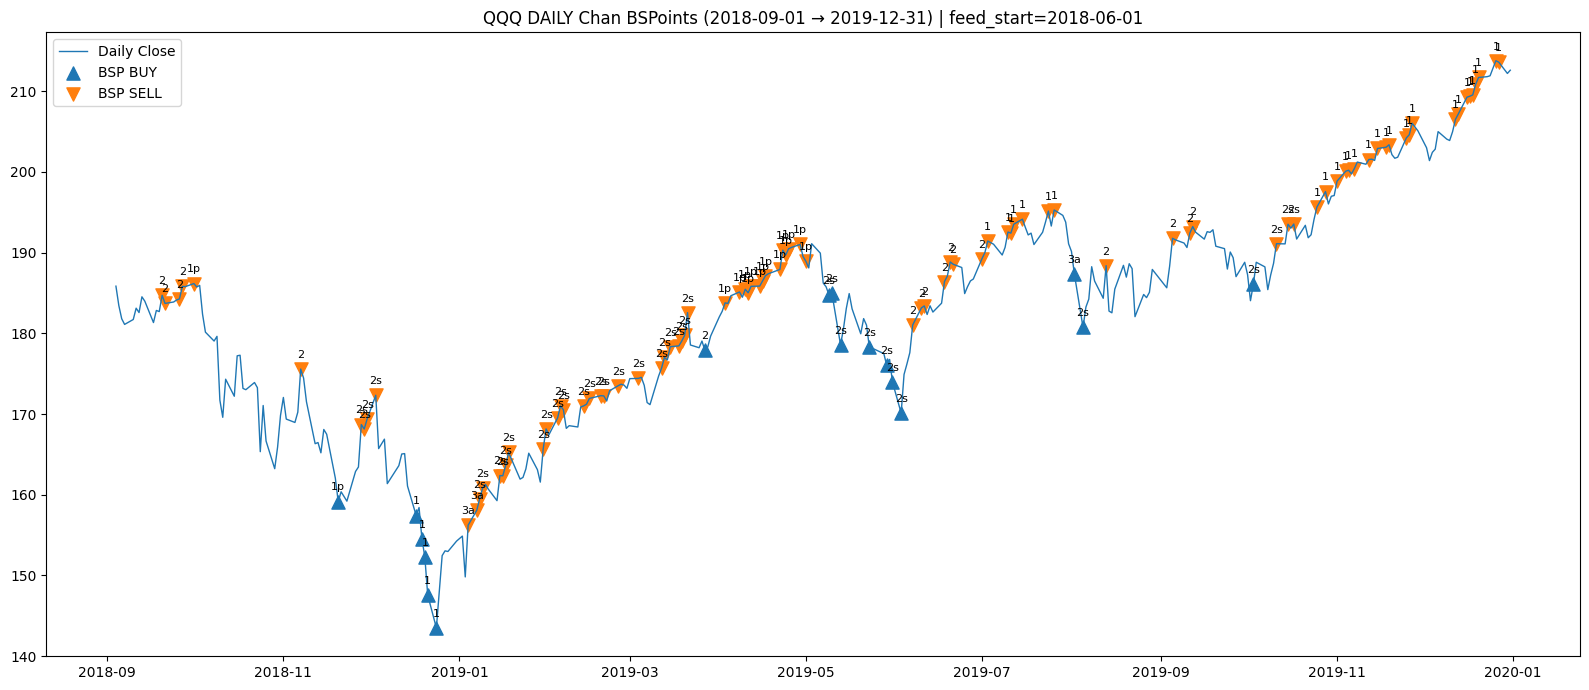

BSPoints total (feed range): 592
BSPoints in plot window: 110
Columns: ['klu_idx', 'timestamp', 'klu_open', 'klu_high', 'klu_low', 'klu_close', 'klu_volume', 'bsp_type', 'bsp_types', 'is_buy', 'direction', 'is_segbsp', 'feat_divergence_rate', 'feat_bsp1_bi_amp', 'feat_bsp1_bi_klu_cnt', 'feat_bsp1_bi_amp_rate', 'feat_macd_value', 'feat_macd_dea', 'feat_macd_diff', 'feat_ppo', 'feat_rsi', 'feat_kdj_k', 'feat_kdj_d', 'feat_kdj_j', 'feat_volume', 'feat_bsp_bi_amp', 'feat_zs_cnt', 'feat_break_bi_amp', 'feat_break_bi_klu_cnt', 'feat_break_bi_amp_rate', 'feat_bi_amp', 'feat_bi_klu_cnt', 'feat_bi_amp_rate', 'feat_level', 'feat_bsp_type', 'macd_value', 'macd_dif', 'macd_dea', 'rsi', 'kdj_k', 'kdj_d', 'kdj_j', 'dmi_plus', 'dmi_minus', 'dmi_adx', 'price_change_pct', 'high_low_spread_pct', 'upper_shadow', 'lower_shadow', 'body_size', 'is_bullish_candle', 'snapshot_first_seen', 'snapshot_last_seen', 'feat_bsp2_retrace_rate', 'feat_bsp2_break_bi_amp', 'feat_bsp2_break_bi_bi_klu_cnt', 'feat_bsp2_brea

,klu_idx,timestamp,klu_open,klu_high,klu_low,klu_close,klu_volume,bsp_type,bsp_types,is_buy,...,feat_bsp2s_break_bi_klu_cnt,feat_bsp2s_break_bi_amp_rate,feat_bsp2s_bi_amp,feat_bsp2s_bi_klu_cnt,feat_bsp2s_bi_amp_rate,feat_bsp2s_lv,feat_bsp3_zs_height,feat_bsp3_bi_amp,feat_bsp3_bi_klu_cnt,feat_bsp3_bi_amp_rate
0,28,2018-07-12,177.20,179.46,177.08,179.46,27930100.0,1p,1p,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29,2018-07-13,179.45,179.90,178.95,179.61,28049800.0,1p,1p,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30,2018-07-16,179.65,179.95,178.88,179.18,21405300.0,1p,1p,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,31,2018-07-17,177.28,180.65,177.28,180.27,31034100.0,1p,1p,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,36,2018-07-24,181.41,182.05,179.56,180.30,36900300.0,1p,1p,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,37,2018-07-25,180.38,182.93,180.29,182.82,35026600.0,1p,1p,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,60,2018-08-27,183.40,184.34,183.11,184.34,29343600.0,1p,1p,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,61,2018-08-28,184.83,185.02,184.22,184.61,20277000.0,1p,1p,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,62,2018-08-29,184.93,186.84,184.86,186.74,29175600.0,1p,1p,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,63,2018-08-30,186.38,187.52,185.79,186.41,29315500.0,1p,1p,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# ============================================================
# Daily Chan BSP plotter (Jupyter single cell)
# - Loads DAILY CSV (e.g., DataAPI/data/QQQ_DAY.csv)
# - Feeds bars into SlidingWindowChan (KL_TYPE.K_DAY)
# - Collects ALL BSPoints produced by the daily chan
# - Plots Close price + BSP markers over a chosen time window
#
# Requirements (your repo in PYTHONPATH):
#   sliding_window_chan.py, ChanConfig.py, Common/CEnum.py,
#   KLine/KLine_Unit.py, Common/CTime.py
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, Any, List, Optional, Tuple

from sliding_window_chan import SlidingWindowChan
from ChanConfig import CChanConfig
from Common.CEnum import DATA_FIELD, KL_TYPE, AUTYPE, DATA_SRC
from KLine.KLine_Unit import CKLine_Unit
from Common.CTime import CTime


# ----------------------------
# Helpers
# ----------------------------

def to_ctime(ts) -> CTime:
    if isinstance(ts, CTime):
        return ts
    dt = pd.to_datetime(ts).to_pydatetime()
    try:
        return CTime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second, auto=False)
    except Exception:
        pass
    try:
        return CTime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    except Exception:
        pass
    s = dt.strftime("%Y-%m-%d %H:%M:%S")
    try:
        return CTime(s, auto=False)
    except Exception:
        return CTime(s)

def build_klu(ts, o, h, l, c, v=0.0) -> CKLine_Unit:
    ct = to_ctime(ts)
    kl_dict = {
        DATA_FIELD.FIELD_TIME: ct,
        DATA_FIELD.FIELD_OPEN: float(o),
        DATA_FIELD.FIELD_HIGH: float(h),
        DATA_FIELD.FIELD_LOW:  float(l),
        DATA_FIELD.FIELD_CLOSE: float(c),
        DATA_FIELD.FIELD_VOLUME: float(v),
        "time": ct, "timestamp": ct, "datetime": ct, "dt": ct,
        "open": float(o), "high": float(h), "low": float(l), "close": float(c),
        "volume": float(v),
    }
    klu = CKLine_Unit(kl_dict)
    try:
        klu.time = ct
    except Exception:
        pass
    return klu

def _pick_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    cols = list(df.columns)
    # exact match
    for c in candidates:
        if c in cols:
            return c
    # case-insensitive match
    lower_map = {c.lower(): c for c in cols}
    for c in candidates:
        if c.lower() in lower_map:
            return lower_map[c.lower()]
    return None

def load_daily_csv(daily_csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(daily_csv_path)

    ts_col = _pick_col(df, ["timestamp", "date", "datetime", "time"])
    if ts_col is None:
        ts_col = df.columns[0]

    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
    df = df.dropna(subset=[ts_col]).sort_values(ts_col).reset_index(drop=True)
    df = df.rename(columns={ts_col: "timestamp"})

    open_col  = _pick_col(df, ["open", "Open"])
    high_col  = _pick_col(df, ["high", "High"])
    low_col   = _pick_col(df, ["low", "Low"])
    close_col = _pick_col(df, ["close", "Close", "adj_close", "Adj Close", "AdjClose"])

    if open_col is None or close_col is None:
        raise ValueError("Daily CSV must contain open and close columns.")
    if high_col is None:
        high_col = close_col
    if low_col is None:
        low_col = close_col

    vol_col = _pick_col(df, ["volume", "Volume", "vol", "Vol"])

    df["_open"]  = pd.to_numeric(df[open_col], errors="coerce")
    df["_high"]  = pd.to_numeric(df[high_col], errors="coerce")
    df["_low"]   = pd.to_numeric(df[low_col], errors="coerce")
    df["_close"] = pd.to_numeric(df[close_col], errors="coerce")
    df["_vol"]   = pd.to_numeric(df[vol_col], errors="coerce") if vol_col is not None else 0.0

    df = df.dropna(subset=["_open", "_high", "_low", "_close"]).reset_index(drop=True)
    return df


# ----------------------------
# Main: run daily chan + plot BSPs
# ----------------------------

def plot_daily_chan_bspoints(
    daily_csv_path: str,
    code: str = "QQQ",
    daily_chan_start: str = "2018-06-01",  # start feeding chan from here (for enough history)
    plot_start: str = "2019-01-01",        # plot window start
    plot_end: str   = "2019-12-31",        # plot window end
    daily_chan_max_klines: int = 600,      # max kline stored inside SlidingWindowChan
    verbose: bool = True,
):
    df = load_daily_csv(daily_csv_path)

    start_dt = pd.to_datetime(daily_chan_start)
    plot_s = pd.to_datetime(plot_start)
    plot_e = pd.to_datetime(plot_end) + pd.Timedelta(hours=23, minutes=59, seconds=59)

    df = df[(df["timestamp"] >= start_dt)].copy().reset_index(drop=True)
    if df.empty:
        raise ValueError("No daily bars after daily_chan_start. Check your date range / CSV.")

    config = CChanConfig({
        "cal_demark": True,
        "cal_kdj": True,
        "cal_dmi": True,
        "cal_rsi": True,
        "cal_rsl": True,
        "cal_demand_index": True,
        "cal_adline": True,
        "cal_bb_vals": True,
        "cal_kc_vals": True,
        "cal_starc_vals": True,
        "bi_strict": True,
        "trigger_step": True,
        "skip_step": 0,
        "divergence_rate": float("inf"),
        "bsp2_follow_1": True,
        "bsp3_follow_1": False,
        "min_zs_cnt": 0,
        "bs1_peak": False,
        "macd_algo": "peak",
        "bs_type": "1,2,3a,1p,2s,3b",
        "print_warning": False,
        "zs_algo": "normal",
    })

    daily_chan = SlidingWindowChan(
        code=code,
        begin_time=None,
        end_time=None,
        data_src=DATA_SRC.CSV,
        lv_list=[KL_TYPE.K_DAY],
        config=config,
        autype=AUTYPE.QFQ,
        max_klines=int(daily_chan_max_klines),
    )

    bsp_rows: List[Dict[str, Any]] = []
    seen = set()

    for i in range(len(df)):
        ts = df.loc[i, "timestamp"]
        klu = build_klu(
            ts=ts,
            o=float(df.loc[i, "_open"]),
            h=float(df.loc[i, "_high"]),
            l=float(df.loc[i, "_low"]),
            c=float(df.loc[i, "_close"]),
            v=float(df.loc[i, "_vol"]) if "_vol" in df.columns else 0.0,
        )

        daily_chan.process_new_kline(klu)

        new_bsp = daily_chan.export_new_historical_bsp_to_list()
        if not new_bsp:
            continue

        # Each exported BSP may not carry full timestamp the way we want;
        # we attach the current bar timestamp as the "seen time".
        for r0 in new_bsp:
            r = dict(r0)
            r.setdefault("timestamp", ts)

            # normalize direction
            if "direction" not in r or r["direction"] is None:
                if r.get("is_buy", None) is not None:
                    r["direction"] = "buy" if bool(r["is_buy"]) else "sell"
                else:
                    r["direction"] = "buy"
            r["direction"] = str(r["direction"]).lower()

            # normalize type as string
            if "bsp_type" in r and r["bsp_type"] is not None:
                r["bsp_type"] = str(r["bsp_type"]).lower()
            else:
                r["bsp_type"] = "?"

            # de-dupe key
            key = (pd.to_datetime(r["timestamp"]).strftime("%Y-%m-%d"), int(r.get("klu_idx", -1)), r["direction"], r["bsp_type"])
            if key in seen:
                continue
            seen.add(key)
            bsp_rows.append(r)

    bsp_df = pd.DataFrame(bsp_rows)
    if bsp_df.empty:
        if verbose:
            print("No BSPoints were produced by daily chan for this range.")
        # still show price plot
        df_plot = df[(df["timestamp"] >= plot_s) & (df["timestamp"] <= plot_e)].copy()
        plt.figure(figsize=(16, 7))
        plt.plot(df_plot["timestamp"], df_plot["_close"], linewidth=1.0)
        plt.title(f"{code} DAILY Close (no BSPoints found in feed range)")
        plt.tight_layout()
        plt.show()
        return bsp_df

    bsp_df["timestamp"] = pd.to_datetime(bsp_df["timestamp"], errors="coerce")
    bsp_df = bsp_df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

    # Plot window
    df_plot = df[(df["timestamp"] >= plot_s) & (df["timestamp"] <= plot_e)].copy()
    bsp_plot = bsp_df[(bsp_df["timestamp"] >= plot_s) & (bsp_df["timestamp"] <= plot_e)].copy()

    # Map BSP timestamp -> close price (daily close at that date)
    close_map = df.set_index(df["timestamp"].dt.normalize())["_close"].to_dict()
    bsp_plot["px"] = bsp_plot["timestamp"].dt.normalize().map(close_map)
    bsp_plot = bsp_plot.dropna(subset=["px"])

    # Plot
    plt.figure(figsize=(16, 7))
    plt.plot(df_plot["timestamp"], df_plot["_close"], linewidth=1.0, label="Daily Close")

    buy_mask = bsp_plot["direction"] == "buy"
    sell_mask = bsp_plot["direction"] == "sell"

    if buy_mask.any():
        plt.scatter(bsp_plot.loc[buy_mask, "timestamp"], bsp_plot.loc[buy_mask, "px"], marker="^", s=90, label="BSP BUY")
    if sell_mask.any():
        plt.scatter(bsp_plot.loc[sell_mask, "timestamp"], bsp_plot.loc[sell_mask, "px"], marker="v", s=90, label="BSP SELL")

    # Light annotations (type)
    # (keep it readable: annotate only if not too many points)
    if len(bsp_plot) <= 120:
        for _, r in bsp_plot.iterrows():
            txt = f"{r.get('bsp_type','?')}"
            plt.annotate(txt, (r["timestamp"], r["px"]), textcoords="offset points", xytext=(0, 8), ha="center", fontsize=8)

    plt.title(f"{code} DAILY Chan BSPoints ({plot_start} → {plot_end}) | feed_start={daily_chan_start}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"BSPoints total (feed range): {len(bsp_df)}")
        print(f"BSPoints in plot window: {len(bsp_plot)}")
        print("Columns:", list(bsp_df.columns))

    return bsp_df


# ============================================================
# RUN (edit here)
# ============================================================

bsp_df = plot_daily_chan_bspoints(
    daily_csv_path="DataAPI/data/QQQ_DAY.csv",
    code="QQQ",
    daily_chan_start="2018-06-01",
    plot_start="2018-09-01",
    plot_end="2019-12-31",
    daily_chan_max_klines=600,
    verbose=True,
)

# Optional: inspect the BSP table
display(bsp_df.head(30))


In [12]:
# generate_testing_data_with_sliding_window_best24h.py
"""
Modified version of testing data generation that uses:
1. Sliding window for memory efficiency
2. BEST reverse signal within 24 hours (instead of just next reverse)
"""

import os
import pandas as pd
import numpy as np
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from datetime import datetime

from sliding_window_chan import SlidingWindowChan
from ChanConfig import CChanConfig
from Common.CEnum import KL_TYPE, DATA_SRC, AUTYPE

# Setup recursion limit
sys.setrecursionlimit(30000)

# Configuration
test_ticker = "SPY"
# begin_time = "2022-06-01"
# end_time = "2022-09-01"
begin_time = "2022-09-02"
end_time = "2022-09-30"
lv_list = [KL_TYPE.K_5M]
lv = KL_TYPE.K_5M
data_src = DATA_SRC.CSV
autype = AUTYPE.QFQ

config = CChanConfig({
    "cal_demark": True,
    "cal_kdj": True,
    "cal_dmi": True,
    "cal_rsi": True,
    "cal_rsl": True,
    "cal_demand_index": True,
    "cal_adline": True,
    "cal_bb_vals": True,
    "cal_kc_vals": True,
    "cal_starc_vals": True,
    "bi_strict": True,
    "trigger_step": True,
    "skip_step": 0,
    "divergence_rate": float("inf"),
    "bsp2_follow_1": True,
    "bsp3_follow_1": False,
    "min_zs_cnt": 0,
    "bs1_peak": False,
    "macd_algo": "peak",
    "bs_type": '1,2,3a,1p,2s,3b',
    "print_warning": False,
    "zs_algo": "normal",
})

output_dir = "./output/testing_bs_features"
os.makedirs(output_dir, exist_ok=True)


def collect_all_bsp_during_step_load(chan: SlidingWindowChan, lv: KL_TYPE) -> tuple:
    """
    Uses sliding window's built-in BSP collection.
    """
    print(f"[⏳] STEP 1: Running step load with sliding window...")
    print(f"[🪟] Window size: {chan.max_klines} K-lines")
    
    snapshot_count = 0
    last_print_time = datetime.now()
    final_chan = None
    
    for snapshot_idx, snapshot_chan in enumerate(chan.step_load()):
        snapshot_count = snapshot_idx + 1
        final_chan = snapshot_chan
        
        now = datetime.now()
        if snapshot_idx % 100 == 0 or (now - last_print_time).total_seconds() > 5:
            stats = chan.get_stats()
            print(f"[📈] Snapshot {snapshot_count}: "
                  f"{stats['total_historical_bsp']} BSP collected, "
                  f"window at idx {stats['window_start_idx']}")
            last_print_time = now
    
    all_bsp_data = chan.export_historical_bsp_to_list()
    
    print(f"[✅] Step load complete: {snapshot_count} snapshots processed")
    print(f"[✅] Collected {len(all_bsp_data)} unique BS points (mature + immature)")
    
    stats = chan.get_stats()
    print(f"\n[📊] Sliding Window Stats:")
    print(f"  Window size: {stats['max_klines']} K-lines")
    print(f"  Final window position: idx {stats['window_start_idx']}")
    if 'current_window_size' in stats:
        print(f"  Current K-lines in window: {stats['current_window_size']}")
    
    return all_bsp_data, final_chan


def calculate_profit_targets_best_within_24h(
    bs_points_with_features: list, 
    time_window_bars: int = 288
) -> dict:
    """
    Calculate profit targets using the BEST reverse signal within a time window.
    
    For BUY signals: Find SELL signal with HIGHEST price within window (max profit)
    For SELL signals: Find BUY signal with LOWEST price within window (max profit)
    
    Args:
        bs_points_with_features: List of BS points with features
        time_window_bars: Number of bars to look ahead (default 288 = 24h of 5-min data)
    
    Returns:
        Dictionary mapping klu_idx to profit target info
    """
    print(f"[🎯] STEP 2: Calculating profit targets using BEST within {time_window_bars} bars (~24h)...")
    
    # Sort by klu_idx to ensure temporal order
    bs_points_with_features.sort(key=lambda x: x['klu_idx'])
    
    profit_targets = {}
    
    for i, data in enumerate(bs_points_with_features):
        current_direction = data['is_buy']
        entry_price = data['klu_close']
        entry_idx = data['klu_idx']
        
        # Initialize
        profit_targets[entry_idx] = {
            'profit_target_pct': None,
            'profit_target_distance': None,
            'has_profit_target': 0,
            'exit_type': None,
            'exit_klu_idx': None,
            'exit_price': None,
        }
        
        # Define the search window (24 hours worth of bars)
        window_end_idx = entry_idx + time_window_bars
        
        # Find ALL reverse signals within the window
        candidates_in_window = []
        fallback_next_reverse = None
        
        for j in range(i + 1, len(bs_points_with_features)):
            future_data = bs_points_with_features[j]
            future_idx = future_data['klu_idx']
            
            # Check if opposite direction
            if future_data['is_buy'] != current_direction:
                # Track first reverse signal as fallback
                if fallback_next_reverse is None:
                    fallback_next_reverse = future_data
                
                # Add to candidates if within window
                if future_idx <= window_end_idx:
                    candidates_in_window.append(future_data)
        
        # Select the BEST candidate within window
        best_exit = None
        
        if candidates_in_window:
            if current_direction:  # BUY signal
                # Find SELL with HIGHEST price (maximum profit for buy)
                best_exit = max(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
            else:  # SELL signal
                # Find BUY with LOWEST price (maximum profit for sell)
                best_exit = min(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
        elif fallback_next_reverse:
            # No reverse signal in 24h window, use next reverse as fallback
            best_exit = fallback_next_reverse
            exit_type = 'fallback_next'
        
        if best_exit is None:
            continue
        
        # Calculate profit percentage
        exit_price = best_exit['klu_close']
        
        if current_direction:  # BUY -> exit at SELL
            profit_pct = (exit_price - entry_price) / entry_price * 100
        else:  # SELL -> exit at BUY
            profit_pct = (entry_price - exit_price) / entry_price * 100
        
        # Store results
        profit_targets[entry_idx] = {
            'profit_target_pct': profit_pct,
            'profit_target_distance': best_exit['klu_idx'] - entry_idx,
            'has_profit_target': 1,
            'exit_type': exit_type,
            'exit_klu_idx': best_exit['klu_idx'],
            'exit_price': exit_price,
        }
    
    # Summary statistics
    valid_targets = [v for v in profit_targets.values() if v['has_profit_target'] == 1]
    
    if valid_targets:
        profits = [v['profit_target_pct'] for v in valid_targets]
        distances = [v['profit_target_distance'] for v in valid_targets]
        exit_types = [v['exit_type'] for v in valid_targets]
        
        best_24h_count = sum(1 for et in exit_types if et == 'best_24h')
        fallback_count = sum(1 for et in exit_types if et == 'fallback_next')
        
        print(f"[📊] Profit Target Summary (BEST within 24h):")
        print(f"  Total BS points: {len(bs_points_with_features)}")
        print(f"  Points with targets: {len(valid_targets)} ({len(valid_targets)/len(bs_points_with_features)*100:.1f}%)")
        print(f"  Exit types:")
        print(f"    - Best within 24h: {best_24h_count} ({best_24h_count/len(valid_targets)*100:.1f}%)")
        print(f"    - Fallback (next reverse): {fallback_count} ({fallback_count/len(valid_targets)*100:.1f}%)")
        print(f"  Average profit: {np.mean(profits):.2f}%")
        print(f"  Median profit: {np.median(profits):.2f}%")
        print(f"  Best profit: {max(profits):.2f}%")
        print(f"  Worst result: {min(profits):.2f}%")
        print(f"  Average distance: {np.mean(distances):.1f} bars")
        print(f"  Profitable trades: {sum(1 for p in profits if p > 0)}/{len(profits)} ({sum(1 for p in profits if p > 0)/len(profits)*100:.1f}%)")
    
    return profit_targets


def prepare_ml_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare dataset for ML"""
    if df.empty:
        return df
    
    print("[🔧] Preparing final ML dataset...")
    
    categorical_cols = ['direction', 'timestamp']
    binary_cols = [col for col in df.columns if col.endswith(('_signal', '_oversold', '_overbought', '_positive', '_up', '_trend_up'))]
    binary_cols.extend(['is_buy', 'is_bullish_candle', 'has_profit_target'])
    
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in categorical_cols and col not in binary_cols]
    
    if numeric_cols:
        numeric_imputer = SimpleImputer(strategy='mean')
        df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
    
    if binary_cols:
        existing_binary_cols = [col for col in binary_cols if col in df.columns]
        if existing_binary_cols:
            binary_imputer = SimpleImputer(strategy='most_frequent')
            df[existing_binary_cols] = binary_imputer.fit_transform(df[existing_binary_cols])
    
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna('unknown')
    
    for col in ['direction']:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    
    df = df.replace([np.inf, -np.inf], np.nan)
    numeric_cols_final = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols_final] = df[numeric_cols_final].fillna(0)
    
    print(f"[✅] Dataset prepared with {len(df)} samples and {len(df.columns)} features")
    return df


def analyze_testing_dataset(df: pd.DataFrame):
    """Analyze testing dataset"""
    print(f"\n[📊] Testing Dataset Analysis:")
    print(f"  Total BS points: {len(df)}")
    print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    
    print(f"\n  Signal Distribution:")
    for direction in ['buy', 'sell']:
        count = (df['direction'] == direction).sum()
        print(f"    {direction.capitalize()}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'bsp_type' in df.columns:
        print(f"\n  BSP Type Distribution:")
        for bsp_type in sorted(df['bsp_type'].unique()):
            count = (df['bsp_type'] == bsp_type).sum()
            print(f"    {bsp_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'exit_type' in df.columns:
        print(f"\n  Exit Type Distribution:")
        exit_counts = df['exit_type'].value_counts()
        for exit_type, count in exit_counts.items():
            if exit_type:
                print(f"    {exit_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'profit_target_pct' in df.columns:
        profit_data = df['profit_target_pct'].dropna()
        if len(profit_data) > 0:
            profitable = (profit_data > 0).sum()
            print(f"\n  Profit Target Performance:")
            print(f"    Points with targets: {len(profit_data)} ({len(profit_data)/len(df)*100:.1f}%)")
            print(f"    Profitable trades: {profitable} ({profitable/len(profit_data)*100:.1f}%)")
            print(f"    Average profit: {profit_data.mean():.2f}%")
            print(f"    Median profit: {profit_data.median():.2f}%")
            print(f"    Min/Max: {profit_data.min():.2f}% / {profit_data.max():.2f}%")


def export_testing_dataset(
    chan: SlidingWindowChan,
    lv: KL_TYPE,
    output_path: str,
    time_window_bars: int = 288,
) -> pd.DataFrame:
    """
    Export testing dataset with BEST within 24h profit logic.
    """
    print(f"[📊] Generating testing dataset with sliding window...")
    print(f"[🔄] Process:")
    print("  STEP 1: Sliding window auto-captures ALL BS points")
    print(f"  STEP 2: Calculate profit targets (BEST within {time_window_bars} bars)")
    
    # STEP 1: Collect all BS points
    all_bsp_data, final_chan = collect_all_bsp_during_step_load(chan, lv)
    
    if not all_bsp_data:
        print("[⚠️] No BS points collected during step load")
        return pd.DataFrame()
    
    # STEP 2: Calculate profit targets using BEST within 24h
    profit_targets = calculate_profit_targets_best_within_24h(
        all_bsp_data, 
        time_window_bars=time_window_bars
    )
    
    # Add profit targets to each row
    for row in all_bsp_data:
        klu_idx = row['klu_idx']
        if klu_idx in profit_targets:
            row.update(profit_targets[klu_idx])
        else:
            row['profit_target_pct'] = None
            row['profit_target_distance'] = None
            row['has_profit_target'] = 0
            row['exit_type'] = None
            row['exit_klu_idx'] = None
            row['exit_price'] = None
    
    # Convert to DataFrame
    df = pd.DataFrame(all_bsp_data)
    
    # Sort by klu_idx
    df = df.sort_values('klu_idx').reset_index(drop=True)
    
    # Prepare final dataset
    df = prepare_ml_dataset(df)
    
    # Analyze dataset
    analyze_testing_dataset(df)
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    print(f"[💾] Saved testing dataset to: {output_path}")
    
    return df


def main():
    try:
        print(f"[🧪] Generating TESTING dataset with SLIDING WINDOW")
        print(f"[📊] Ticker: {test_ticker}")
        print(f"[📅] Period: {begin_time} to {end_time}")
        print(f"[🪟] Window: 1000 K-lines (configurable)")
        print(f"[🎯] Profit Logic: BEST reverse signal within 24 hours")
        
        # Calculate appropriate time window based on K-line type
        time_windows = {
            KL_TYPE.K_5M: 288,   # 24 hours = 288 5-min bars
            KL_TYPE.K_15M: 96,   # 24 hours = 96 15-min bars
            KL_TYPE.K_30M: 48,   # 24 hours = 48 30-min bars
            KL_TYPE.K_60M: 24,   # 24 hours = 24 1-hour bars
            KL_TYPE.K_DAY: 1,    # 24 hours = 1 day bar
        }
        
        time_window = time_windows.get(lv, 288)
        print(f"[⏰] Time window: {time_window} bars (~24 hours for {lv.name})")
        
        # Create sliding window Chan
        chan = SlidingWindowChan(
            code=test_ticker,
            begin_time=begin_time,
            end_time=end_time,
            data_src=data_src,
            lv_list=lv_list,
            config=config,
            autype=autype,
            max_klines=1000
        )
        
        # Export testing dataset
        output_file = os.path.join(output_dir, f"{test_ticker}_testing_dataset_22.9.2-9.30.csv")
        df = export_testing_dataset(
            chan=chan,
            lv=lv,
            output_path=output_file,
            time_window_bars=time_window,
        )
        
        if df is not None and not df.empty:
            # Display sample data
            print("\n[📋] Sample of testing data:")
            sample_cols = ['klu_idx', 'bsp_type', 'direction', 'snapshot_first_seen',
                          'profit_target_pct', 'profit_target_distance', 'exit_type', 
                          'has_profit_target']
            available_sample_cols = [col for col in sample_cols if col in df.columns]
            print(df[available_sample_cols].head(20))
            
            # Sliding window benefits
            stats = chan.get_stats()
            print(f"\n[🪟] Sliding Window Benefits:")
            print(f"  ✅ Memory efficient: Only {stats['max_klines']} K-lines in RAM")
            print(f"  ✅ Faster processing: Smaller Chan system to recalculate")
            print(f"  ✅ Complete data: All {stats['total_historical_bsp']} BSP preserved")
            print(f"  ✅ Scalable: Can process unlimited historical data")
            print(f"  ✅ Better targets: Uses BEST exit within 24h (not just next)")
            
            # Save metadata
            metadata_path = os.path.join(output_dir, f"{test_ticker}_best24h_metadata.txt")
            with open(metadata_path, 'w') as f:
                f.write("Testing Dataset with BEST within 24h Logic\n")
                f.write("=" * 50 + "\n\n")
                
                f.write("PROFIT TARGET CALCULATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Method: BEST reverse signal within {time_window} bars (~24 hours)\n")
                f.write("Logic:\n")
                f.write("  - BUY signals: Find SELL with HIGHEST price in window\n")
                f.write("  - SELL signals: Find BUY with LOWEST price in window\n")
                f.write("  - Fallback: Uses next reverse if no signal in window\n\n")
                
                f.write("ADVANTAGES over 'Next Reverse' method:\n")
                f.write("-" * 30 + "\n")
                f.write("1. Captures MAXIMUM profit potential within timeframe\n")
                f.write("2. More realistic (traders wait for best exit, not just first)\n")
                f.write("3. Aligned with actual trading behavior\n")
                f.write("4. Still time-constrained (24h) to avoid overfitting\n\n")
                
                f.write("SLIDING WINDOW CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Window Size: {stats['max_klines']} K-lines\n")
                f.write(f"Final Window Position: idx {stats['window_start_idx']}\n")
                f.write(f"Total BSP Collected: {stats['total_historical_bsp']}\n\n")
                
                f.write("CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Ticker: {test_ticker}\n")
                f.write(f"Period: {begin_time} to {end_time}\n")
                f.write(f"Level: {lv.name}\n")
                f.write(f"Time Window: {time_window} bars (~24 hours)\n")
                f.write(f"Total Samples: {len(df)}\n")
                f.write(f"Samples with Targets: {df['has_profit_target'].sum()}\n")
                
                if 'exit_type' in df.columns:
                    f.write(f"\nExit Type Distribution:\n")
                    exit_counts = df['exit_type'].value_counts()
                    for exit_type, count in exit_counts.items():
                        if exit_type:
                            f.write(f"  {exit_type}: {count} ({count/len(df)*100:.1f}%)\n")
            
            print(f"[📝] Metadata saved to: {metadata_path}")
            
            print("\n[✅] Testing dataset generation complete!")
            print(f"\n[🎯] Key Features:")
            print(f"  ✅ Uses BEST exit within 24h (max profit potential)")
            print(f"  ✅ More realistic than 'next reverse' logic")
            print(f"  ✅ Captures ALL BS points during step load")
            print(f"  ✅ No future data in features")
            print(f"  ✅ Memory efficient with sliding window")
            print(f"  ✅ Ready for model testing")
        
        return df
        
    except Exception as e:
        print(f"[❌] Error: {e}")
        import traceback
        traceback.print_exc()
        return None


if __name__ == "__main__":
    import time
    
    start_time = time.time()
    
    # Run the testing dataset generation
    testing_data = main()
    
    end_time = time.time()
    print(f"\n⏱️ Total processing time: {end_time - start_time:.2f} seconds")
    
    if testing_data is not None and not testing_data.empty:
        print("\n[🧪] Testing Dataset Ready!")
        print(f"Dataset shape: {testing_data.shape}")
        
        print(f"\n[📊] This dataset uses:")
        print(f"  ✅ BEST reverse signal within 24h (max profit)")
        print(f"  ✅ More realistic exit logic")
        print(f"  ✅ Features without future data leak")
        print(f"  ✅ Generated efficiently with sliding window")
    else:
        print("[❌] No testing data was generated.")

[🧪] Generating TESTING dataset with SLIDING WINDOW
[📊] Ticker: SPY
[📅] Period: 2022-09-02 to 2022-09-30
[🪟] Window: 1000 K-lines (configurable)
[🎯] Profit Logic: BEST reverse signal within 24 hours
[⏰] Time window: 288 bars (~24 hours for K_5M)
[📊] Generating testing dataset with sliding window...
[🔄] Process:
  STEP 1: Sliding window auto-captures ALL BS points
  STEP 2: Calculate profit targets (BEST within 288 bars)
[⏳] STEP 1: Running step load with sliding window...
[🪟] Window size: 1000 K-lines
[📥] Loading K-lines from data source...
CSV_API: Processed 1044283 lines, filtered to 3824 lines
[✅] Loaded 3824 K-lines from source
[🪟] Starting sliding window processing (window size: 1000)
[📊] Total K-lines to process: 3824
[📈] Snapshot 1: 0 BSP collected, window at idx 0
[📈] Snapshot 101: 3 BSP collected, window at idx 0
[📈] Snapshot 201: 28 BSP collected, window at idx 0
[📈] Snapshot 301: 48 BSP collected, window at idx 0
[📈] Snapshot 396: 59 BSP collected, window at idx 0
[📈] Snapsho